### Ячейка 1: Импорты

In [53]:
# -*- coding: utf-8 -*-
# =============================================================================
# Ячейка 1: Импорты и Базовая Настройка
# =============================================================================
print("--- Ячейка 1: Импорты и Базовая Настройка ---")

# --- Базовые библиотеки ---
import numpy as np
import pandas as pd
import os
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'
import zipfile
import time
import warnings
import json
import random
import traceback
from pathlib import Path
from typing import Union # Для аннотаций типов (Python < 3.10)

# --- Аудио и Сигналы ---
import librosa
import librosa.display
import scipy
import scipy.signal as signal

# --- Визуализация и Интерактивность ---
try:
    import ipywidgets as widgets
    from IPython.display import display, Audio, clear_output
    IPYWIDGETS_AVAILABLE = True
except ImportError: IPYWIDGETS_AVAILABLE = False
import matplotlib.pyplot as plt

# --- PyTorch ---
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F
from torch.optim.lr_scheduler import OneCycleLR

# --- Метрики и Утилиты ---
import Levenshtein
from tqdm.notebook import tqdm

import mlflow
import mlflow.pytorch

# --- Настройка окружения и предупреждений ---
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", message="The verbose parameter is deprecated")
warnings.filterwarnings("ignore", message="You are using `torch.load` with `weights_only=False`")

print("\n--- Статус библиотек ---")
print(f"PyTorch Версия: {torch.__version__}")
print(f"LibROSA Версия: {librosa.__version__}")
# ... (остальные версии) ...
print(f"ipywidgets доступен: {IPYWIDGETS_AVAILABLE}")
print("-" * 50)
# =============================================================================

--- Ячейка 1: Импорты и Базовая Настройка ---

--- Статус библиотек ---
PyTorch Версия: 2.5.1+cu121
LibROSA Версия: 0.11.0
ipywidgets доступен: True
--------------------------------------------------


### Ячейка 2: Конфигурация и Параметры

In [ ]:
# =============================================================================
# Ячейка 2: Конфигурация и Параметры (ЭКСПЕРИМЕНТ: SR=44100 Гц, BS=8)
# =============================================================================
print("--- Ячейка 2: Конфигурация и Параметры (ЭКСПЕРИМЕНТ: SR=44100 Гц, BS=8) ---")
print("Запускаем с batch_size=8. Ожидается длительное выполнение.")

SEED = 42 # Фиксируем SEED

# --- Пути ---
BASE_DIR = Path('./').resolve(); ZIP_PATH = BASE_DIR / 'morse_dataset.zip'
AUDIO_DIR_NAME = 'morse_dataset'; EXTRACTED_AUDIO_DIR = BASE_DIR / AUDIO_DIR_NAME / AUDIO_DIR_NAME
TRAIN_CSV_PATH = BASE_DIR / 'train.csv'; TEST_CSV_PATH = BASE_DIR / 'test.csv'
SAMPLE_SUB_PATH = BASE_DIR / 'sample_submission.csv'
OUTPUT_DIR = BASE_DIR / 'output'; OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print(f"Базовая директория: {BASE_DIR}")
print(f"Директория для аудио: {EXTRACTED_AUDIO_DIR}")
print(f"Директория для вывода: {OUTPUT_DIR}")

# --- Параметры обработки аудио ---
AUDIO_CONFIG = {
    "sample_rate": 8000, # <<<--- 44100 Гц
    "frame_length_rms": 128 ,
    "hop_length_rms": 441,
    "apply_filter": False, # Фильтр отключен
    "filter_order": 5,     # (Игнорируется)
    "filter_fmin": 0,      # (Игнорируется)
    "filter_fmax": 22049,  # (Игнорируется)
    "normalization_mode": "zscore",
    "delta_type": 'standard',
    "delta_alpha": 1.0,
    "rms_smoothing_window_size": 1,
    "delta_ma_smoothing_window_size": 1,
    "fixed_crop_start_sec": 0,
    "fixed_crop_end_sec": 0,
}
print(f"\nАудио параметры: {json.dumps(AUDIO_CONFIG, indent=2)}")
print(f"  (Частота Найквиста: {AUDIO_CONFIG['sample_rate'] / 2.0} Гц)")

# --- Параметры Модели (Стандартные) ---
MODEL_CONFIG = {
    "input_feature_dim": 2,
    "cnn_out_channels": [64, 128, 128],
    "cnn_kernel_size": 9, "cnn_stride": 1, "cnn_padding": 'same',
    "cnn_pool_kernel": 2, "rnn_hidden_size": 256, "rnn_num_layers": 2,
    "dropout_rate": 0.2,
    "activation_fn": "GELU"
}
print(f"\nПараметры модели: {json.dumps(MODEL_CONFIG, indent=2)}")

# --- Параметры Обучения (BS=8, 20 ЭПОХ) ---
TRAIN_CONFIG = {
    "batch_size": 8,                    # <<<--- ВОЗВРАЩАЕМ 8
    "num_workers": 0,
    "num_epochs": 15,                   # <<<--- УВЕЛИЧИВАЕМ КОЛ-ВО ЭПОХ
    "learning_rate": 2e-4,
    "final_div_factor": 100,
    "weight_decay": 1e-4,
    "optimizer": "AdamW",
    "noise_level": 0.0,
    "early_stopping_patience": 5,       # <<<--- Ставим 7 (или 5, если хочешь быстрее)
    "gradient_clip_norm": 2.0,
    "validation_split_ratio": 0.1,
    "base_seed": SEED
}
print(f"\nПараметры основного обучения: {json.dumps(TRAIN_CONFIG, indent=2)}")

# --- Специальные Токены и Глобальные Переменные ---
PAD_TOKEN = '<pad>'; BLANK_TOKEN = '_'; PAD_IDX = -1; BLANK_IDX = -1; NUM_CLASSES_CTC = -1
char_to_index = {}; index_to_char = {}

# --- Формирование Имен Файлов для Сохранения ---
sr_suffix = f"_SR{AUDIO_CONFIG['sample_rate'] // 1000}k" # _SR44k
norm_mode_suffix = f"_Norm{AUDIO_CONFIG.get('normalization_mode','zscore').capitalize()}"
filter_status_suffix = "_FiltON" if AUDIO_CONFIG.get("apply_filter", True) else "_FiltOFF"
crop_start = AUDIO_CONFIG.get("fixed_crop_start_sec", 0); crop_end = AUDIO_CONFIG.get("fixed_crop_end_sec", 0)
crop_suffix = f"_cropS{crop_start:.1f}E{crop_end:.1f}s" if crop_start > 0 or crop_end > 0 else "_cropNONE"

BASE_FILENAME_SUFFIX = f"RMS{AUDIO_CONFIG['frame_length_rms']}h{AUDIO_CONFIG['hop_length_rms']}_" \
                         f"CNNk{MODEL_CONFIG['cnn_kernel_size']}p{MODEL_CONFIG['cnn_pool_kernel']}_" \
                         f"RNN{MODEL_CONFIG['rnn_hidden_size']}x{MODEL_CONFIG['rnn_num_layers']}_" \
                         f"Feat{MODEL_CONFIG['input_feature_dim']}_" \
                         f"LR{TRAIN_CONFIG['learning_rate']:.0e}_" \
                         f"WD{TRAIN_CONFIG['weight_decay']:.0e}"

FINAL_SUFFIX = f"{sr_suffix}_Delta{AUDIO_CONFIG['delta_type']}{norm_mode_suffix}{filter_status_suffix}{crop_suffix}"
MODEL_SAVE_PATH_TEMPLATE = str(OUTPUT_DIR / f"model_{BASE_FILENAME_SUFFIX}")
PARAMS_SAVE_PATH_TEMPLATE = str(OUTPUT_DIR / f"params_{BASE_FILENAME_SUFFIX}")

BEST_MODEL_PATH = Path(f"{MODEL_SAVE_PATH_TEMPLATE}{FINAL_SUFFIX}.pth")
PARAMS_PATH = Path(f"{PARAMS_SAVE_PATH_TEMPLATE}{FINAL_SUFFIX}.json")

print(f"\nПуть для модели: {BEST_MODEL_PATH}")
print(f"Путь для параметров: {PARAMS_PATH}")

# --- Выбор устройства ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nИспользуемое устройство: {device}")
if device.type == 'cuda': print(f"  GPU: {torch.cuda.get_device_name(0)}")

# --- Установка SEED ---
def set_seed(seed_value):
    random.seed(seed_value); np.random.seed(seed_value); torch.manual_seed(seed_value)
    if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed_value)
    print(f"Установлен SEED = {seed_value}")
set_seed(TRAIN_CONFIG['base_seed'])

print("\n--- Ячейка 2: Конфигурация для эксперимента 'SR=44100 Гц, BS=8' завершена ---")
print("-" * 50)
# =============================================================================

--- Ячейка 2: Конфигурация и Параметры (ЭКСПЕРИМЕНТ: SR=44100 Гц, BS=8) ---
Запускаем с batch_size=8. Ожидается длительное выполнение.
Базовая директория: C:\Users\vasja\OneDrive\Рабочий стол\MorseAudioDecoder
Директория для аудио: C:\Users\vasja\OneDrive\Рабочий стол\MorseAudioDecoder\morse_dataset\morse_dataset
Директория для вывода: C:\Users\vasja\OneDrive\Рабочий стол\MorseAudioDecoder\output

Аудио параметры: {
  "sample_rate": 44100,
  "frame_length_rms": 1764,
  "hop_length_rms": 441,
  "apply_filter": false,
  "filter_order": 5,
  "filter_fmin": 0,
  "filter_fmax": 22049,
  "normalization_mode": "zscore",
  "delta_type": "standard",
  "delta_alpha": 1.0,
  "rms_smoothing_window_size": 1,
  "delta_ma_smoothing_window_size": 1,
  "fixed_crop_start_sec": 0,
  "fixed_crop_end_sec": 0
}
  (Частота Найквиста: 22050.0 Гц)

Параметры модели: {
  "input_feature_dim": 2,
  "cnn_out_channels": [
    64,
    128,
    128
  ],
  "cnn_kernel_size": 9,
  "cnn_stride": 1,
  "cnn_padding": "sam

### Ячейка 3: Загрузка данных и распаковка

In [55]:
# =============================================================================
# Ячейка 3: Загрузка Данных и Распаковка
# =============================================================================
print("--- Ячейка 3: Загрузка метаданных и распаковка аудио ---")
# --- Проверка и Распаковка Архива ---
if not EXTRACTED_AUDIO_DIR.exists():
    print(f"Папка {EXTRACTED_AUDIO_DIR} не найдена.")
    if ZIP_PATH.is_file():
        print(f"Распаковка {ZIP_PATH.name}...")
        try:
            with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref: zip_ref.extractall(BASE_DIR)
            print("Архив распакован.")
            if not EXTRACTED_AUDIO_DIR.is_dir():
                 possible_audio_dir = BASE_DIR / ZIP_PATH.stem
                 if possible_audio_dir.is_dir(): EXTRACTED_AUDIO_DIR = possible_audio_dir; print(f"Найдена папка: {EXTRACTED_AUDIO_DIR}")
                 else: raise FileNotFoundError(f"Не удалось найти папку с аудио после распаковки.")
            else: print(f"Найдена папка: {EXTRACTED_AUDIO_DIR}")
        except Exception as e: print(f"Критическая ошибка при распаковке: {e}"); raise SystemExit("Остановка.")
    else: print(f"Критическая ошибка: Архив {ZIP_PATH} не найден."); raise SystemExit("Остановка.")
else: print(f"Папка {EXTRACTED_AUDIO_DIR} уже существует.")

# --- Загрузка CSV ---
print("\nЗагрузка CSV файлов...")
try:
    train_df = pd.read_csv(TRAIN_CSV_PATH); print(f"  Train: {len(train_df)} записей.")
    test_df = pd.read_csv(TEST_CSV_PATH); print(f"  Test: {len(test_df)} записей.")
    try: sample_sub_df = pd.read_csv(SAMPLE_SUB_PATH); print(f"  Sample Sub: {len(sample_sub_df)} записей.")
    except FileNotFoundError: print(f"  Предупреждение: {SAMPLE_SUB_PATH.name} не найден."); sample_sub_df = None
except FileNotFoundError as e: print(f"Критическая ошибка: CSV файл не найден: {e}."); raise SystemExit("Остановка.")
except Exception as e: print(f"Критическая ошибка при чтении CSV: {e}"); raise SystemExit("Остановка.")

# --- Проверка наличия аудио ---
print("\nВыборочная проверка аудиофайлов...")
if train_df is not None and not train_df.empty and EXTRACTED_AUDIO_DIR.is_dir():
    example_path = EXTRACTED_AUDIO_DIR / train_df['id'].iloc[0]
    if example_path.is_file(): print(f"  Пример файла найден: {example_path}")
    else: print(f"  !!! ПРЕДУПРЕЖДЕНИЕ: Пример файла НЕ найден: {example_path} !!!")
elif not EXTRACTED_AUDIO_DIR.is_dir(): print(f"  Проверка невозможна: Папка {EXTRACTED_AUDIO_DIR} не существует.")
else: print("  Проверка невозможна (train_df пуст?).")

print("\n--- Ячейка 3: Загрузка данных завершена ---")
print("-" * 50)
# =============================================================================

--- Ячейка 3: Загрузка метаданных и распаковка аудио ---
Папка C:\Users\vasja\OneDrive\Рабочий стол\MorseAudioDecoder\morse_dataset\morse_dataset уже существует.

Загрузка CSV файлов...
  Train: 30000 записей.
  Test: 5000 записей.
  Sample Sub: 5000 записей.

Выборочная проверка аудиофайлов...
  Пример файла найден: C:\Users\vasja\OneDrive\Рабочий стол\MorseAudioDecoder\morse_dataset\morse_dataset\1.opus

--- Ячейка 3: Загрузка данных завершена ---
--------------------------------------------------


### Ячейка 4: Создание словаря символов

In [56]:
# =============================================================================
# Ячейка 4: Создание Словаря Символов
# =============================================================================
print("--- Ячейка 4: Создание словаря символов ---")
if train_df is None or 'message' not in train_df.columns:
    raise SystemExit("Остановка: train_df не загружен или нет колонки 'message'.")
try:
    all_texts = train_df['message'].fillna('').astype(str)
    unique_chars = sorted(list(set(char for text in all_texts for char in text)))
    char_to_index = {char: i for i, char in enumerate(unique_chars)}
    index_to_char = {i: char for char, i in char_to_index.items()}
    BLANK_IDX = len(char_to_index); PAD_IDX = len(char_to_index) + 1
    char_to_index[BLANK_TOKEN] = BLANK_IDX; char_to_index[PAD_TOKEN] = PAD_IDX
    index_to_char[BLANK_IDX] = BLANK_TOKEN; index_to_char[PAD_IDX] = PAD_TOKEN
    NUM_CLASSES_CTC = BLANK_IDX + 1
    print(f"Найдено уникальных символов: {len(unique_chars)}")
    print(f"Размер словаря (вкл. BLANK, PAD): {len(char_to_index)}")
    print(f"Индекс BLANK ('{BLANK_TOKEN}'): {BLANK_IDX}"); print(f"Индекс PAD ('{PAD_TOKEN}'): {PAD_IDX}")
    print(f"Количество классов для CTC Loss: {NUM_CLASSES_CTC}")
except Exception as e: print(f"Критическая ошибка: {e}"); traceback.print_exc(); raise SystemExit("Остановка.")
if not char_to_index or not index_to_char or BLANK_IDX == -1 or PAD_IDX == -1 or NUM_CLASSES_CTC <= 0:
    raise SystemExit("Остановка: Ошибка инициализации словаря.")
print("\n--- Ячейка 4: Создание словаря завершено ---")
print("-" * 50)
# =============================================================================

--- Ячейка 4: Создание словаря символов ---
Найдено уникальных символов: 44
Размер словаря (вкл. BLANK, PAD): 46
Индекс BLANK ('_'): 44
Индекс PAD ('<pad>'): 45
Количество классов для CTC Loss: 45

--- Ячейка 4: Создание словаря завершено ---
--------------------------------------------------


### Ячейка 5: Класс MorseDataset

In [57]:
# =============================================================================
# Ячейка 5: Класс MorseDataset (ФИНАЛЬНАЯ ВЕРСИЯ - без сглаживания)
# =============================================================================
print("--- Ячейка 5: Определение класса MorseDataset ---")
# Проверка глобальных переменных
if 'BLANK_IDX' not in globals() or BLANK_IDX==-1 or 'PAD_IDX' not in globals() or PAD_IDX==-1: raise ValueError("BLANK_IDX/PAD_IDX не инициализированы.")
if 'AUDIO_CONFIG' not in globals() or not AUDIO_CONFIG: raise ValueError("AUDIO_CONFIG не определена.")
if 'TRAIN_CONFIG' not in globals() or not TRAIN_CONFIG: raise ValueError("TRAIN_CONFIG не определена.")
if 'MODEL_CONFIG' not in globals() or not MODEL_CONFIG: raise ValueError("MODEL_CONFIG не определена.")

class MorseDataset(Dataset):
    """
    Датасет для Морзе. Фильтр -> RMS -> Delta -> Z-score Norm.
    Сглаживание ОТКЛЮЧЕНО. Trimming пока НЕ реализован.
    """
    def __init__(self, dataframe: pd.DataFrame, audio_dir: Path, char_to_index: dict,
                 audio_config: dict, model_input_feature_dim: int,
                 train_config: dict, is_train: bool = True):
        # (Проверки типов...)
        self.dataframe = dataframe.reset_index(drop=True)
        self.audio_dir = audio_dir; self.char_to_index = char_to_index; self.is_train = is_train
        self.audio_config = audio_config; self.train_config = train_config
        self.expected_feature_dim = model_input_feature_dim
        # Параметры аудио
        self.sample_rate = self.audio_config['sample_rate']; self.frame_length_rms = self.audio_config['frame_length_rms']
        self.hop_length_rms = self.audio_config['hop_length_rms']; self.filter_order = self.audio_config['filter_order']
        self.filter_fmin = self.audio_config['filter_fmin']; self.filter_fmax = self.audio_config['filter_fmax']
        self.delta_type = self.audio_config.get('delta_type', 'standard'); self.delta_alpha = self.audio_config.get('delta_alpha', 1.0)
        self.noise_level = self.train_config.get('noise_level', 0) if self.is_train else 0
        # Проверки
        self.nyquist = self.sample_rate / 2.0
        if self.filter_fmax >= self.nyquist: self.filter_fmax = self.nyquist * 0.999
        if 'id' not in self.dataframe.columns: raise ValueError("Нет колонки 'id'.")
        if self.is_train and 'message' not in self.dataframe.columns: raise ValueError("Нет колонки 'message'.")
        print(f"MorseDataset создан: is_train={self.is_train}, delta_type='{self.delta_type}', "
              f"Фильтр={self.filter_fmin}-{int(self.filter_fmax)}Hz (Порядок {self.filter_order}), "
              f"Сглаживание RMS/Delta=ВЫКЛ, Шум={self.noise_level:.1f}")

    def __len__(self): return len(self.dataframe)

    def _apply_filter(self, waveform_np: np.ndarray) -> np.ndarray:
        # (Код фильтра Баттерворта без изменений, как в предыдущих версиях)
        if not isinstance(waveform_np, np.ndarray) or waveform_np.ndim != 1: return waveform_np
        f_min = self.filter_fmin; f_max = min(self.filter_fmax, self.nyquist * 0.999)
        is_lowcut_needed = f_min > 1e-3; is_highcut_needed = f_max < (self.nyquist * 0.995)
        if not is_lowcut_needed and not is_highcut_needed: return waveform_np.astype(np.float32)
        try:
            if is_lowcut_needed and is_highcut_needed: ftype, freqs = 'bandpass', [f_min, f_max]
            elif is_lowcut_needed: ftype, freqs = 'highpass', f_min
            else: ftype, freqs = 'lowpass', f_max
            if isinstance(freqs, list) and freqs[0] >= freqs[1]: return waveform_np.astype(np.float32)
            sos = signal.butter(self.filter_order, freqs, btype=ftype, fs=self.sample_rate, output='sos')
            return signal.sosfiltfilt(sos, waveform_np).astype(np.float32)
        except ValueError as ve: print(f"WARNING: Filter ValueError: {ve}."); return waveform_np.astype(np.float32)
        except Exception as e: print(f"WARNING: Filter Error: {e}."); traceback.print_exc(limit=1); return waveform_np.astype(np.float32)

    def _normalize_feature(self, feature_array: np.ndarray) -> np.ndarray:
        # Стандартный Z-score
        epsilon = 1e-6; mean = np.mean(feature_array); std = np.std(feature_array)
        return (feature_array - mean) / (std + epsilon)

    def _calculate_features(self, waveform_np: np.ndarray, file_id_for_log: str = "N/A") -> Union[torch.Tensor, None]:
        """ Вычисляет признаки. Сглаживание отключено. """
        empty_tensor = torch.empty((self.expected_feature_dim, 0), dtype=torch.float32)
        if not isinstance(waveform_np, np.ndarray) or waveform_np.size == 0: return empty_tensor
        try:
            # 1. Фильтрация
            filtered_waveform = self._apply_filter(waveform_np)
            if filtered_waveform.size == 0: return empty_tensor
            # 2. Расчет RMS
            rms_envelope_raw = librosa.feature.rms(y=filtered_waveform, frame_length=self.frame_length_rms, hop_length=self.hop_length_rms, center=True, pad_mode='reflect')[0]
            if rms_envelope_raw.size < 2: return empty_tensor
            # 3. Сглаживание RMS - ПРОПУСКАЕТСЯ
            rms_envelope_processed = rms_envelope_raw
            # 4. Расчет Дельты
            delta_standard = np.diff(rms_envelope_processed, n=1, prepend=rms_envelope_processed[0])
            delta_raw = delta_standard # (остальные типы дельты пока не используются)
            # 5. Сглаживание Дельты - ПРОПУСКАЕТСЯ
            delta_processed = delta_raw
            # 6. Нормализация (Z-score) и Формирование Выхода
            features_to_stack = [self._normalize_feature(rms_envelope_processed), self._normalize_feature(delta_processed)]
            features_np = np.vstack(features_to_stack).astype(np.float32)
            features_tensor = torch.from_numpy(features_np)
            if features_tensor.shape[0] != self.expected_feature_dim:
                 print(f"ERROR ({file_id_for_log}): Wrong feature dim: {features_tensor.shape[0]}"); return None
            return features_tensor
        except Exception as e:
             print(f"CRITICAL ERROR in _calculate_features ({file_id_for_log}): {e}"); traceback.print_exc(limit=1); return None

    def __getitem__(self, index: int):
        # (Код без изменений по сравнению с предыдущими версиями - пока без Trimming)
        if not (0 <= index < len(self.dataframe)): return None, (None if self.is_train else f"InvalidIndex_{index}")
        try: row = self.dataframe.iloc[index]; file_id = row['id']; audio_path = self.audio_dir / file_id
        except Exception as e: return None, (None if self.is_train else f"DataAccessError_{index}_{e}")
        # 1. Загрузка/Ресэмплинг (БЕЗ Trimming)
        try:
            waveform_np, sr_original = librosa.load(audio_path, sr=self.sample_rate, mono=True)
            if waveform_np.size == 0: return None, (file_id if not self.is_train else None)
        except FileNotFoundError: print(f"ERROR ({file_id}): Not found: {audio_path}"); return None, (file_id if not self.is_train else None)
        except Exception as e: print(f"ERROR ({file_id}): Load error: {e}"); traceback.print_exc(limit=1); return None, (file_id if not self.is_train else None)
        # 2. Зашумление - ПРОПУСКАЕТСЯ (noise_level = 0)
        # 3. Вычисление Признаков
        features = self._calculate_features(waveform_np, file_id_for_log=file_id)
        if features is None or features.shape[1] == 0: return None, (file_id if not self.is_train else None)
        # 4. Таргет / ID
        if self.is_train:
            message_text = str(row.get('message', '')); target_indices = [self.char_to_index.get(c, BLANK_IDX) for c in message_text]
            if not target_indices or all(idx == BLANK_IDX for idx in target_indices): return None, None
            target_tensor = torch.tensor(target_indices, dtype=torch.long); return features, target_tensor
        else: return features, file_id

print("\n--- Ячейка 5: Определение MorseDataset завершено ---")
print("-" * 50)
# =============================================================================

--- Ячейка 5: Определение класса MorseDataset ---

--- Ячейка 5: Определение MorseDataset завершено ---
--------------------------------------------------


### Ячейка 6: Функция collate_fn

In [58]:
# =============================================================================
# Ячейка 6: Функция collate_fn (Сборка Батчей)
# =============================================================================
print("--- Ячейка 6: Определение функции collate_fn ---")
if 'PAD_IDX' not in globals() or PAD_IDX == -1: raise ValueError("PAD_IDX не инициализирован!")

def collate_fn(batch):
    """ Собирает батч, фильтрует None, выполняет паддинг. """
    original_batch_size = len(batch)
    valid_batch = [(f, t) for f, t in batch if f is not None and t is not None and f.shape[1] > 0]
    filtered_batch_size = len(valid_batch)
    if filtered_batch_size == 0: return None
    is_train_batch = isinstance(valid_batch[0][1], torch.Tensor)
    features_list = [item[0].permute(1, 0) for item in valid_batch] # (Time, Features)
    targets_or_ids_list = [item[1] for item in valid_batch]
    # Pad Features: -> (Batch, MaxTime, Features) -> (Batch, Features, MaxTime)
    features_padded = pad_sequence(features_list, batch_first=True, padding_value=0.0).permute(0, 2, 1)
    feature_lengths = torch.tensor([f[0].shape[1] for f in valid_batch], dtype=torch.long) # Original time lengths
    if is_train_batch:
        targets_list = targets_or_ids_list
        targets_padded = pad_sequence(targets_list, batch_first=True, padding_value=PAD_IDX)
        target_lengths = torch.tensor([len(t) for t in targets_list], dtype=torch.long)
        return features_padded, targets_padded, feature_lengths, target_lengths
    else:
        file_ids = targets_or_ids_list
        return features_padded, file_ids, feature_lengths, None

print("Функция collate_fn определена.")
print("\n--- Ячейка 6: Определение collate_fn завершено ---")
print("-" * 50)
# =============================================================================

--- Ячейка 6: Определение функции collate_fn ---
Функция collate_fn определена.

--- Ячейка 6: Определение collate_fn завершено ---
--------------------------------------------------


### Ячейка 7: Модель MorseRecognizer

In [59]:
# =============================================================================
# Ячейка 7: Модель MorseRecognizer (CNN + BiGRU)
# =============================================================================
print("--- Ячейка 7: Определение модели MorseRecognizer ---")
if 'MODEL_CONFIG' not in globals() or not MODEL_CONFIG: raise ValueError("MODEL_CONFIG не определена!")
if 'NUM_CLASSES_CTC' not in globals() or NUM_CLASSES_CTC <= 0: raise ValueError("NUM_CLASSES_CTC не инициализирована!")

class MorseRecognizer(nn.Module):
    """ Модель: CNN Extractor + BiGRU + Classifier """
    def __init__(self, num_classes_ctc: int, input_feature_dim: int, cnn_out_channels: list,
                 cnn_kernel_size: int, cnn_stride: int, cnn_padding, cnn_pool_kernel: int,
                 rnn_hidden_size: int, rnn_num_layers: int, dropout_rate: float, activation_fn: str = "GELU"):
        super().__init__()
        self.input_feature_dim = input_feature_dim; self._time_reduction_factor = 1.0
        # --- CNN ---
        cnn_layers = []; in_channels = input_feature_dim
        try: ActivationLayer = getattr(nn, activation_fn)
        except AttributeError: print(f"Warning: Активация '{activation_fn}' -> GELU."); ActivationLayer = nn.GELU
        for i, out_channels in enumerate(cnn_out_channels):
            layer = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, cnn_kernel_size, cnn_stride, cnn_padding),
                nn.BatchNorm1d(out_channels), ActivationLayer(),
                nn.MaxPool1d(cnn_pool_kernel), nn.Dropout(dropout_rate) )
            cnn_layers.append(layer); in_channels = out_channels; self._time_reduction_factor *= cnn_pool_kernel
        self.cnn_extractor = nn.Sequential(*cnn_layers); self.cnn_output_dim = in_channels
        # --- RNN (BiGRU) ---
        self.rnn = nn.GRU(self.cnn_output_dim, rnn_hidden_size, rnn_num_layers,
                          batch_first=True, bidirectional=True, dropout=dropout_rate if rnn_num_layers > 1 else 0)
        # --- Classifier ---
        self.classifier = nn.Linear(rnn_hidden_size * 2, num_classes_ctc)
        print("Архитектура MorseRecognizer инициализирована.")

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if x.shape[1] != self.input_feature_dim: raise ValueError(f"Wrong input features: {x.shape[1]} vs {self.input_feature_dim}")
        x = self.cnn_extractor(x)  # (B, C_cnn, T_red)
        x = x.permute(0, 2, 1)     # (B, T_red, C_cnn)
        x_rnn, _ = self.rnn(x)     # (B, T_red, H*2)
        logits = self.classifier(x_rnn) # (B, T_red, Classes)
        return logits.permute(1, 0, 2)  # (T_red, B, Classes) for CTC

    def get_time_reduction_factor(self) -> float: return self._time_reduction_factor

# --- Создание и Проверка Модели ---
model_created_successfully = False; model = None
try:
    print("\nСоздание экземпляра модели...")
    model = MorseRecognizer(num_classes_ctc=NUM_CLASSES_CTC, **MODEL_CONFIG).to(device)
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Модель '{type(model).__name__}' создана на '{device}'. Параметры: {total_params:,}")
    # --- Проверка forward pass ---
    print("\nПроверка forward pass..."); model.eval()
    dummy_input = torch.randn(2, MODEL_CONFIG['input_feature_dim'], 500).to(device)
    with torch.no_grad(): dummy_output = model(dummy_input)
    print(f"  Вход: {dummy_input.shape}, Выход: {dummy_output.shape}")
    expected_time = int(dummy_input.shape[2] / model.get_time_reduction_factor())
    if abs(dummy_output.shape[0] - expected_time) > 2: print(f"  ПРЕДУПРЕЖДЕНИЕ: Неожиданная длина выхода по времени! Ожидалось ~{expected_time}, получено {dummy_output.shape[0]}.")
    assert dummy_output.shape[1] == 2, "Batch size mismatch!"
    assert dummy_output.shape[2] == NUM_CLASSES_CTC, "Num classes mismatch!"
    print("  Размерности выхода корректны."); model_created_successfully = True
except Exception as e: print(f"\n!!! Ошибка создания/проверки модели: {e} !!!"); traceback.print_exc(); model = None
if not model_created_successfully: raise SystemExit("Остановка: Не удалось создать/проверить модель.")

print("\n--- Ячейка 7: Определение и проверка модели завершены ---")
print("-" * 50)
# =============================================================================

--- Ячейка 7: Определение модели MorseRecognizer ---

Создание экземпляра модели...
Архитектура MorseRecognizer инициализирована.
Модель 'MorseRecognizer' создана на 'cuda'. Параметры: 2,021,997

Проверка forward pass...


  Вход: torch.Size([2, 2, 500]), Выход: torch.Size([62, 2, 45])
  Размерности выхода корректны.

--- Ячейка 7: Определение и проверка модели завершены ---
--------------------------------------------------


### Ячейка 8: Loss, Optimizer, Scheduler

In [60]:
# =============================================================================
# Ячейка 8: Функция Потерь (Loss) и Оптимизатор
# =============================================================================
print("--- Ячейка 8: Настройка Loss и Optimizer ---")
if not model_created_successfully or model is None: raise SystemExit("Остановка: Модель не создана.")
if BLANK_IDX == -1: raise ValueError("BLANK_IDX не инициализирован!")

# 1. Loss: CTC Loss
criterion = nn.CTCLoss(blank=BLANK_IDX, reduction='mean', zero_infinity=True).to(device)
print(f"Функция потерь: CTCLoss (blank={BLANK_IDX}, reduction='mean', zero_infinity=True)")

# 2. Optimizer
optimizer_name = TRAIN_CONFIG.get('optimizer', 'AdamW').lower()
lr = TRAIN_CONFIG['learning_rate']; wd = TRAIN_CONFIG['weight_decay']; optimizer = None
print(f"\nВыбор оптимизатора: {optimizer_name.upper()}")
if optimizer_name == 'adamw': optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
elif optimizer_name == 'adam': optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
else: print(f"Предупреждение: Неизвестный '{optimizer_name}'. Используется AdamW."); optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
print(f"Оптимизатор: {type(optimizer).__name__} (lr={lr:.1e}, weight_decay={wd:.1e})")

# 3. Scheduler - Инициализируется в Ячейке 13 перед обучением
scheduler = None
print("Планировщик: OneCycleLR (будет инициализирован перед циклом обучения)")

print("\n--- Ячейка 8: Настройка Loss и Optimizer завершена ---")
print("-" * 50)
# =============================================================================

--- Ячейка 8: Настройка Loss и Optimizer ---
Функция потерь: CTCLoss (blank=44, reduction='mean', zero_infinity=True)

Выбор оптимизатора: ADAMW
Оптимизатор: AdamW (lr=2.0e-04, weight_decay=1.0e-04)
Планировщик: OneCycleLR (будет инициализирован перед циклом обучения)

--- Ячейка 8: Настройка Loss и Optimizer завершена ---
--------------------------------------------------


### Ячейка 9: Функции Декодирования и Метрики

In [61]:
# =============================================================================
# Ячейка 9: Функции Декодирования (Greedy) и Метрики (Levenshtein)
# =============================================================================
print("--- Ячейка 9: Определение функций декодирования (Greedy) и метрики ---")
if 'index_to_char' not in globals() or not index_to_char or BLANK_IDX == -1 or PAD_IDX == -1:
     raise ValueError("Словарь index_to_char или индексы BLANK/PAD не определены!")

# --- Greedy CTC Decoding ---
def ctc_greedy_decode(logits: torch.Tensor, index_to_char_map: dict, blank_idx: int) -> list[str]:
    decoded_batch = []
    best_path = torch.argmax(logits, dim=2) # (Time, Batch)
    best_path_np = best_path.cpu().numpy()
    for i in range(best_path_np.shape[1]): # Iterate over batch
        sequence_indices = best_path_np[:, i]
        collapsed_indices = [idx for j, idx in enumerate(sequence_indices) if j == 0 or idx != sequence_indices[j-1]]
        final_indices = [idx for idx in collapsed_indices if idx != blank_idx]
        decoded_string = "".join([index_to_char_map.get(idx, '?') for idx in final_indices])
        decoded_batch.append(decoded_string)
    return decoded_batch

# --- Levenshtein Distance ---
def calculate_levenshtein(predictions: list[str], targets_padded: torch.Tensor,
                          target_lengths: torch.Tensor, index_to_char_map: dict,
                          pad_idx: int) -> tuple[float, list[tuple[str, str]]]:
    total_distance = 0.0; num_valid_pairs = 0; decoded_pairs = []
    batch_size = targets_padded.shape[0]
    targets_np = targets_padded.cpu().numpy(); target_lengths_np = target_lengths.cpu().numpy()
    if len(predictions) != batch_size: print(f"Warning: Levenshtein size mismatch!"); return float('inf'), []
    for i in range(batch_size):
        real_len = target_lengths_np[i]; pred_str = predictions[i]
        if real_len <= 0: target_str = ""; dist = len(pred_str)
        else:
            target_indices = targets_np[i, :real_len]
            target_str = "".join([index_to_char_map.get(idx, '?') for idx in target_indices if idx != pad_idx])
            try: dist = Levenshtein.distance(pred_str, target_str)
            except Exception as e: print(f"Levenshtein Error: {e}"); dist = max(len(pred_str), len(target_str))
        total_distance += dist; num_valid_pairs += 1; decoded_pairs.append((pred_str, target_str))
    mean_lev = total_distance / num_valid_pairs if num_valid_pairs > 0 else float('inf')
    return mean_lev, decoded_pairs

print("Функции ctc_greedy_decode и calculate_levenshtein определены.")
print("\n--- Ячейка 9: Определение функций декодирования и метрики завершено ---")
print("-" * 50)
# =============================================================================

--- Ячейка 9: Определение функций декодирования (Greedy) и метрики ---
Функции ctc_greedy_decode и calculate_levenshtein определены.

--- Ячейка 9: Определение функций декодирования и метрики завершено ---
--------------------------------------------------


### Ячейка 10: Функции Обучения и Валидации Эпохи

In [62]:
# =============================================================================
# Ячейка 10: Функции Обучения и Валидации Эпохи
# =============================================================================
print("--- Ячейка 10: Определение функций обучения и валидации эпохи ---")
# Проверки... (Проверяем основные функции и переменные)
if 'ctc_greedy_decode' not in globals() or 'calculate_levenshtein' not in globals(): raise NameError("Функции decode/metric не определены.")
if BLANK_IDX == -1 or PAD_IDX == -1: raise ValueError("Индексы BLANK/PAD не определены!")
if 'model' not in globals() or model is None: raise NameError("Модель 'model' не определена!")
if 'device' not in globals(): raise NameError("Переменная 'device' не определена!")
if 'index_to_char' not in globals() or not index_to_char: raise NameError("Словарь 'index_to_char' не определен!")

# --- Train Epoch ---
def train_epoch(model: nn.Module, dataloader: DataLoader, criterion: nn.CTCLoss,
                optimizer: optim.Optimizer, scheduler: optim.lr_scheduler._LRScheduler,
                device: torch.device, epoch_num: int, total_epochs: int,
                index_to_char_map: dict, blank_idx: int, pad_idx: int,
                grad_clip_norm: float) -> tuple[float, float, float]:
    model.train(); running_loss = 0.0; total_lev_dist = 0.0; total_lr = 0.0; num_batches = 0; total_samples = 0
    try: time_factor = model.get_time_reduction_factor()
    except AttributeError: time_factor = 1.0
    time_factor = max(time_factor, 1.0)
    pbar = tqdm(dataloader, desc=f"Эпоха {epoch_num}/{total_epochs} [Тренировка]", leave=False, ncols=1000)

    for batch_idx, batch_data in enumerate(pbar):
        if batch_data is None: continue
        features, targets, feature_lengths, target_lengths = batch_data
        if features is None or targets is None: continue
        batch_size = features.size(0);
        if batch_size == 0: continue
        # Move to device
        features = features.to(device, non_blocking=True); targets = targets.to(device, non_blocking=True)
        feature_lengths_cpu = feature_lengths.cpu(); target_lengths_cpu = target_lengths.cpu()
        input_lengths_ctc = torch.floor(feature_lengths_cpu.float() / time_factor + 1e-9).long().clamp(min=1)
        # Training step
        loss_value = float('inf'); lev_dist_batch = float('inf')
        current_lr = optimizer.param_groups[0]['lr']; total_lr += current_lr; num_batches += 1
        try:
            optimizer.zero_grad(); logits = model(features); output_length = logits.shape[0] # (T, B, C)
            if logits.shape[1] != batch_size: continue # Safety check
            log_probs = F.log_softmax(logits, dim=2)
            input_lengths_ctc_clamped = input_lengths_ctc.clamp(max=output_length)
            target_lengths_clamped = target_lengths_cpu.clamp(max=targets.shape[1])
            loss = criterion(log_probs, targets, input_lengths_ctc_clamped, target_lengths_clamped)
            if not torch.isfinite(loss): print(f"Warning: NaN/Inf loss in batch {batch_idx}. Skip step."); optimizer.zero_grad(); continue
            loss_value = loss.item()
            loss.backward()
            if grad_clip_norm > 0: torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=grad_clip_norm)
            optimizer.step()
            if scheduler: scheduler.step() # OneCycleLR step per batch
            # Calc Levenshtein (no grad)
            with torch.no_grad():
                decoded_preds = ctc_greedy_decode(logits, index_to_char_map, blank_idx)
                lev_dist_batch, _ = calculate_levenshtein(decoded_preds, targets.cpu(), target_lengths_cpu, index_to_char_map, pad_idx)
        except RuntimeError as e:
             if "CUDA out of memory" in str(e): print("\n!!! CUDA OOM Error !!!"); raise e
             else: print(f"\nRuntimeError batch {batch_idx}: {e}"); traceback.print_exc(); loss_value=30.0; lev_dist_batch=float('inf')
        except Exception as e: print(f"\nTrain Error batch {batch_idx}: {e}"); traceback.print_exc(); loss_value=30.0; lev_dist_batch=float('inf')
        # Update stats
        if np.isfinite(loss_value): running_loss += loss_value * batch_size
        else: running_loss += 30.0 * batch_size
        lev_to_add = lev_dist_batch if np.isfinite(lev_dist_batch) else (features.shape[2] / 10.0)
        total_lev_dist += lev_to_add * batch_size; total_samples += batch_size
        pbar.set_postfix(loss=f'{loss_value:.4f}', lev=f'{lev_dist_batch:.4f}', lr=f'{current_lr:.2e}')
    pbar.close()
    avg_loss = running_loss / total_samples if total_samples > 0 else float('inf')
    avg_lev = total_lev_dist / total_samples if total_samples > 0 else float('inf')
    avg_lr = total_lr / num_batches if num_batches > 0 else 0.0
    return avg_loss, avg_lev, avg_lr

# --- Validate Epoch ---
def validate_epoch(model: nn.Module, dataloader: DataLoader, criterion: nn.CTCLoss,
                   device: torch.device, index_to_char_map: dict,
                   blank_idx: int, pad_idx: int) -> tuple[float, float, list[tuple[str, str]]]:
    model.eval(); running_loss = 0.0; total_lev_dist = 0.0; total_samples = 0; all_decoded_pairs = []
    try: time_factor = model.get_time_reduction_factor()
    except AttributeError: time_factor = 1.0
    time_factor = max(time_factor, 1.0)
    pbar = tqdm(dataloader, desc="   [Валидация]", leave=False, ncols=1000)
    with torch.no_grad():
        for batch_data in pbar:
            if batch_data is None: continue
            features, targets, feature_lengths, target_lengths = batch_data
            if features is None or targets is None: continue
            batch_size = features.size(0);
            if batch_size == 0: continue
            features = features.to(device, non_blocking=True); targets = targets.to(device, non_blocking=True)
            feature_lengths_cpu = feature_lengths.cpu(); target_lengths_cpu = target_lengths.cpu()
            input_lengths_ctc = torch.floor(feature_lengths_cpu.float() / time_factor + 1e-9).long().clamp(min=1)
            loss_value = float('inf'); lev_dist_batch = float('inf'); decoded_pairs_batch = []
            try:
                logits = model(features); output_length = logits.shape[0]
                if logits.shape[1] != batch_size: continue
                log_probs = F.log_softmax(logits, dim=2)
                input_lengths_ctc_clamped = input_lengths_ctc.clamp(max=output_length)
                target_lengths_clamped = target_lengths_cpu.clamp(max=targets.shape[1])
                loss = criterion(log_probs, targets, input_lengths_ctc_clamped, target_lengths_clamped)
                if torch.isfinite(loss): loss_value = loss.item()
                decoded_preds = ctc_greedy_decode(logits, index_to_char_map, blank_idx)
                lev_dist_batch, decoded_pairs_batch = calculate_levenshtein(
                    decoded_preds, targets.cpu(), target_lengths_cpu, index_to_char_map, pad_idx )
            except Exception as e: print(f"\nVal Error: {e}"); traceback.print_exc(limit=1); loss_value=inf; lev_dist_batch=inf; decoded_pairs_batch = [("ERROR","")]*batch_size
            # Update stats
            if np.isfinite(loss_value): running_loss += loss_value * batch_size
            lev_to_add = lev_dist_batch if np.isfinite(lev_dist_batch) else (features.shape[2] / 10.0)
            total_lev_dist += lev_to_add * batch_size; total_samples += batch_size
            if len(all_decoded_pairs) < 15: all_decoded_pairs.extend(decoded_pairs_batch)
            pbar.set_postfix(loss=f'{loss_value:.4f}', lev=f'{lev_dist_batch:.4f}')
    pbar.close()
    avg_loss = running_loss / total_samples if total_samples > 0 else float('inf')
    avg_lev = total_lev_dist / total_samples if total_samples > 0 else float('inf')
    return avg_loss, avg_lev, all_decoded_pairs

print("Функции train_epoch и validate_epoch определены.")
print("\n--- Ячейка 10: Определение функций обучения и валидации завершено ---")
print("-" * 50)
# =============================================================================

--- Ячейка 10: Определение функций обучения и валидации эпохи ---
Функции train_epoch и validate_epoch определены.

--- Ячейка 10: Определение функций обучения и валидации завершено ---
--------------------------------------------------


### 12.1: Вывод Финальной Конфигурации

In [63]:
print("\n--- 12.1: Финальная Конфигурация Перед Обучением ---")
print("AUDIO_CONFIG:")
print(json.dumps(AUDIO_CONFIG, indent=2))
print("\nMODEL_CONFIG:")
print(json.dumps(MODEL_CONFIG, indent=2))
print("\nTRAIN_CONFIG:")
print(json.dumps(TRAIN_CONFIG, indent=2))
print("\nПути для сохранения:")
print(f"  Модель: {BEST_MODEL_PATH}")
print(f"  Параметры: {PARAMS_PATH}")
print("-" * 30)


--- 12.1: Финальная Конфигурация Перед Обучением ---
AUDIO_CONFIG:
{
  "sample_rate": 44100,
  "frame_length_rms": 1764,
  "hop_length_rms": 441,
  "apply_filter": false,
  "filter_order": 5,
  "filter_fmin": 0,
  "filter_fmax": 22049,
  "normalization_mode": "zscore",
  "delta_type": "standard",
  "delta_alpha": 1.0,
  "rms_smoothing_window_size": 1,
  "delta_ma_smoothing_window_size": 1,
  "fixed_crop_start_sec": 0,
  "fixed_crop_end_sec": 0
}

MODEL_CONFIG:
{
  "input_feature_dim": 2,
  "cnn_out_channels": [
    64,
    128,
    128
  ],
  "cnn_kernel_size": 9,
  "cnn_stride": 1,
  "cnn_padding": "same",
  "cnn_pool_kernel": 2,
  "rnn_hidden_size": 256,
  "rnn_num_layers": 2,
  "dropout_rate": 0.2,
  "activation_fn": "GELU"
}

TRAIN_CONFIG:
{
  "batch_size": 8,
  "num_workers": 0,
  "num_epochs": 15,
  "learning_rate": 0.0002,
  "final_div_factor": 100,
  "weight_decay": 0.0001,
  "optimizer": "AdamW",
  "noise_level": 0.0,
  "early_stopping_patience": 5,
  "gradient_clip_norm": 2.

### Ячейка 12.4: Интерактивная Визуализация Сигналов и Дельт для Разных Фильтров

In [64]:
# 12.4: Интерактивная Визуализация Признаков (Опционально)
print("\n--- 12.4: Визуализация Признаков (Опционально) ---")
if IPYWIDGETS_AVAILABLE and 'train_df' in globals() and train_df is not None and not train_df.empty \
   and 'AUDIO_CONFIG' in globals() and 'EXTRACTED_AUDIO_DIR' in globals() and EXTRACTED_AUDIO_DIR.is_dir() \
   and 'MorseDataset' in globals() and 'TRAIN_CONFIG' in globals():
    # (Код визуализации из Ячейки 12.4 предыдущих версий - без изменений)
    # (Важно: он использует MorseDataset._apply_filter и _calculate_features
    #  с текущими AUDIO_CONFIG, т.е. покажет признаки БЕЗ сглаживания)
    # --- Параметры ---
    sr_vis=AUDIO_CONFIG['sample_rate']; frame_len_vis=AUDIO_CONFIG['frame_length_rms']; hop_len_vis=AUDIO_CONFIG['hop_length_rms']
    delta_type_vis=AUDIO_CONFIG.get('delta_type', 'standard'); delta_alpha_vis=AUDIO_CONFIG.get('delta_alpha', 1.0)
    fmin_vis=AUDIO_CONFIG.get('filter_fmin', 0); fmax_vis=AUDIO_CONFIG.get('filter_fmax', 4000)
    # --- Функция расчета (без сглаж. и норм.) ---
    def calculate_vis_features_raw_vis(waveform_np, sr, frame, hop, delta_t, delta_a):
        rms_env = np.array([]); delta_fin = np.array([])
        if not isinstance(waveform_np, np.ndarray) or waveform_np.size==0: return rms_env, delta_fin
        try:
            temp_ds = MorseDataset(pd.DataFrame({'id':['d']}), Path('.'), {}, AUDIO_CONFIG, 2, TRAIN_CONFIG, is_train=False)
            wf_filt = temp_ds._apply_filter(waveform_np); del temp_ds
            if wf_filt.size==0: return rms_env, delta_fin
            rms_env = librosa.feature.rms(y=wf_filt, frame_length=frame, hop_length=hop, center=True, pad_mode='reflect')[0]
            if rms_env.size<2: return rms_env, delta_fin
            delta_std = np.diff(rms_env, n=1, prepend=rms_env[0]); delta_fin = delta_std
            #if delta_t=='cubed': delta_fin = np.power(delta_a*delta_std,3) # Add other types if needed
            return rms_env, delta_fin
        except Exception as e: print(f"Vis Error: {e}"); return rms_env, delta_fin
    # --- Виджеты ---
    file_ids_vis = train_df['id'].unique().tolist(); file_ids_vis=file_ids_vis[:500]
    file_dd_vis = widgets.Dropdown(options=file_ids_vis, description='Файл:', style={'description_width': 'initial'}, layout=widgets.Layout(width='80%'))
    output_vis = widgets.Output()
    # --- Функция обновления ---
    def update_vis(change):
        fid = file_dd_vis.value
        with output_vis:
            clear_output(wait=True); print(f"Файл: {fid} (Без сглаживания)")
            path = EXTRACTED_AUDIO_DIR / fid;
            if not path.is_file(): print(f"Не найден: {path}"); return
            try:
                wf, _ = librosa.load(path, sr=sr_vis, mono=True);
                if wf.size==0: print("Пустой waveform"); return
                display(Audio(data=wf, rate=sr_vis))
                rms_v, delta_v = calculate_vis_features_raw_vis(wf, sr_vis, frame_len_vis, hop_len_vis, delta_type_vis, delta_alpha_vis)
                fig,ax = plt.subplots(2,1,figsize=(14,6),sharex=True)
                fig.suptitle(f"Признаки: {fid} | Фильтр: {fmin_vis}-{fmax_vis}Hz | Без сглаживания",fontsize=14)
                times_v = librosa.times_like(rms_v, sr=sr_vis, hop_length=hop_len_vis) if rms_v.size>0 else np.array([])
                ax[0].plot(times_v, rms_v, label='RMS (Raw)', c='b', lw=1); ax[0].set_title("RMS"); ax[0].legend(); ax[0].grid(True, ls=':');
                if rms_v.size>0: ax[0].set_ylim(0, np.max(rms_v)*1.1 if np.max(rms_v)>0 else 1)
                ax[1].plot(times_v, delta_v, label=f'Delta ({delta_type_vis}, Raw)', c='r', lw=1); ax[1].axhline(0, c='k', ls=':', lw=1)
                ax[1].set_title("Delta"); ax[1].legend(); ax[1].grid(True, ls=':'); ax[1].set_xlabel("Время (с)")
                if delta_v.size>0: mn,mx=np.min(delta_v),np.max(delta_v); marg=(mx-mn)*0.1 if (mx-mn)>1e-6 else 0.1; ax[1].set_ylim(mn-marg,mx+marg)
                plt.tight_layout(rect=[0,0.03,1,0.93]); plt.show()
            except Exception as e: print(f"Vis Error {fid}: {e}"); traceback.print_exc(limit=1)
    # --- Отображение ---
    file_dd_vis.observe(update_vis, names='value')
    controls_vis = widgets.VBox([widgets.HTML("<b>Визуализация признаков (RMS/Delta):</b>"), file_dd_vis])
    ui_vis = widgets.VBox([controls_vis, output_vis])
    display(ui_vis)
    if not train_df.empty: update_vis(None)
else: print("Визуализация пропущена (ipywidgets не найден / данные отсутствуют).")


print("\n--- Ячейка 12: Завершена ---")
print("-" * 50)
# =============================================================================


--- 12.4: Визуализация Признаков (Опционально) ---



--- Ячейка 12: Завершена ---
--------------------------------------------------


### Ячейка 13: Основной Цикл Обучения

--- Ячейка 13: Запуск Основного Цикла Обучения (с MLflow) ---
MLflow Версия: 2.21.3

Подготовка Dataset и DataLoaders...
MorseDataset создан: is_train=True, delta_type='standard', Фильтр=0-22049Hz (Порядок 5), Сглаживание RMS/Delta=ВЫКЛ, Шум=0.0
Разделение: Train=27000, Validation=3000
Созданы Train (3375 батчей) и Val (188 батчей) DataLoaders.

Инициализация OneCycleLR: total_steps=50625, max_lr=2.0e-04, final_div_factor=100
Планировщик OneCycleLR создан.

Настройка MLflow...
MLflow готов. Логи будут сохраняться локально в папку './mlruns'.
Запустите 'mlflow ui' в терминале в папке проекта для просмотра.

--- Начало основного обучения (15 эпох) ---
MLflow Run ID: 2a71073d685c40ab921888069450eba2
Модель будет сохранена как: model_RMS1764h441_CNNk9p2_RNN256x2_Feat2_LR2e-04_WD1e-04_SR44k_Deltastandard_NormZscore_FiltOFF_cropNONE.pth
Логирование параметров в MLflow...

--- Эпоха 1/15 ---


Эпоха 1/15 [Тренировка]:   0%|                                                                                …

   [Валидация]:   0%|                                                                                         …


Итоги Эпохи 1/15 | Время: 385.99 сек | Ср.LR: 1.561e-05
  Train Loss: 5.4150 | Train Levenshtein: 9.2906
  Val Loss:   4.3081 | Val Levenshtein:   8.8780
  Примеры декодирования (Greedy):
    1: '' | 'ФААР834ОМП'
    2: '' | 'Т0С ЖЩ0О БМЫ'
    3: '' | 'ЬЛННЖЗУЯН3ЭХ7'
    4: '' | 'АИИ9Ъ9ОЭЯЕ'
    5: '' | '#6ЧФ8ЮО'
  ✨ Val Lev улучшился: inf -> 8.8780. Сохранение локальной модели...
  Временная модель сохранена в: C:\Users\vasja\OneDrive\Рабочий стол\MorseAudioDecoder\output\temp_best_model_mlflow_2a71073d685c40ab921888069450eba2.pth
------------------------------------------------------------

--- Эпоха 2/15 ---


Эпоха 2/15 [Тренировка]:   0%|                                                                                …

   [Валидация]:   0%|                                                                                         …


Итоги Эпохи 2/15 | Время: 383.75 сек | Ср.LR: 5.697e-05
  Train Loss: 1.7580 | Train Levenshtein: 4.0302
  Val Loss:   0.5381 | Val Levenshtein:   1.1387
  Примеры декодирования (Greedy):
    1: 'ФААР83ЮШМП' | 'ФААР834ОМП'
    2: 'Т0С ЖЩ0З БМЫ' | 'Т0С ЖЩ0О БМЫ'
    3: 'ЬЛННЖЗУЯН3ЭХЛ' | 'ЬЛННЖЗУЯН3ЭХ7'
    4: 'АИИ9Ъ9ОЭЯЕ' | 'АИИ9Ъ9ОЭЯЕ'
    5: '#6ЧФ8ЮО' | '#6ЧФ8ЮО'
  ✨ Val Lev улучшился: 8.8780 -> 1.1387. Сохранение локальной модели...
  Временная модель сохранена в: C:\Users\vasja\OneDrive\Рабочий стол\MorseAudioDecoder\output\temp_best_model_mlflow_2a71073d685c40ab921888069450eba2.pth
------------------------------------------------------------

--- Эпоха 3/15 ---


Эпоха 3/15 [Тренировка]:   0%|                                                                                …

   [Валидация]:   0%|                                                                                         …


Итоги Эпохи 3/15 | Время: 388.85 сек | Ср.LR: 1.203e-04
  Train Loss: 0.5414 | Train Levenshtein: 1.1926
  Val Loss:   0.4339 | Val Levenshtein:   0.9897
  Примеры декодирования (Greedy):
    1: 'ФААР83ЮОМП' | 'ФААР834ОМП'
    2: 'ТОС ЖЩ0З БМЫ' | 'Т0С ЖЩ0О БМЫ'
    3: 'ЬЛННЖЗУЯН3ЭХЛ' | 'ЬЛННЖЗУЯН3ЭХ7'
    4: 'АИИ9Ъ9ОЭЯЕ' | 'АИИ9Ъ9ОЭЯЕ'
    5: '#6ЧФ8ЮО' | '#6ЧФ8ЮО'
  ✨ Val Lev улучшился: 1.1387 -> 0.9897. Сохранение локальной модели...
  Временная модель сохранена в: C:\Users\vasja\OneDrive\Рабочий стол\MorseAudioDecoder\output\temp_best_model_mlflow_2a71073d685c40ab921888069450eba2.pth
------------------------------------------------------------

--- Эпоха 4/15 ---


Эпоха 4/15 [Тренировка]:   0%|                                                                                …

   [Валидация]:   0%|                                                                                         …


Итоги Эпохи 4/15 | Время: 387.04 сек | Ср.LR: 1.761e-04
  Train Loss: 0.4510 | Train Levenshtein: 1.0447
  Val Loss:   0.3882 | Val Levenshtein:   0.9110
  Примеры декодирования (Greedy):
    1: 'ФААР83ЮОМП' | 'ФААР834ОМП'
    2: 'ТС ЖЩ0 БМЫ' | 'Т0С ЖЩ0О БМЫ'
    3: 'ЬЛННЖЗУЯН3ЭХ' | 'ЬЛННЖЗУЯН3ЭХ7'
    4: 'АИИ9Ъ9ОЭЯЕ' | 'АИИ9Ъ9ОЭЯЕ'
    5: '#6ЧФ8ЮО' | '#6ЧФ8ЮО'
  ✨ Val Lev улучшился: 0.9897 -> 0.9110. Сохранение локальной модели...
  Временная модель сохранена в: C:\Users\vasja\OneDrive\Рабочий стол\MorseAudioDecoder\output\temp_best_model_mlflow_2a71073d685c40ab921888069450eba2.pth
------------------------------------------------------------

--- Эпоха 5/15 ---


Эпоха 5/15 [Тренировка]:   0%|                                                                                …

   [Валидация]:   0%|                                                                                         …


Итоги Эпохи 5/15 | Время: 388.02 сек | Ср.LR: 1.988e-04
  Train Loss: 0.4020 | Train Levenshtein: 0.9494
  Val Loss:   0.3616 | Val Levenshtein:   0.8667
  Примеры декодирования (Greedy):
    1: 'ФААР83ЮОМП' | 'ФААР834ОМП'
    2: 'КОС ЖЩ0З БМЫ' | 'Т0С ЖЩ0О БМЫ'
    3: 'ЬЛННЖЗУЯН3ЭХ7' | 'ЬЛННЖЗУЯН3ЭХ7'
    4: 'АИИ9Ъ9ОЭЯЕ' | 'АИИ9Ъ9ОЭЯЕ'
    5: '#6ЧФ8ЮО' | '#6ЧФ8ЮО'
  ✨ Val Lev улучшился: 0.9110 -> 0.8667. Сохранение локальной модели...
  Временная модель сохранена в: C:\Users\vasja\OneDrive\Рабочий стол\MorseAudioDecoder\output\temp_best_model_mlflow_2a71073d685c40ab921888069450eba2.pth
------------------------------------------------------------

--- Эпоха 6/15 ---


Эпоха 6/15 [Тренировка]:   0%|                                                                                …

   [Валидация]:   0%|                                                                                         …


Итоги Эпохи 6/15 | Время: 388.18 сек | Ср.LR: 1.952e-04
  Train Loss: 0.3700 | Train Levenshtein: 0.8927
  Val Loss:   0.3329 | Val Levenshtein:   0.7887
  Примеры декодирования (Greedy):
    1: 'ФААР83ЮОМЪ' | 'ФААР834ОМП'
    2: 'ТТС ЖЩ0З БМЫ' | 'Т0С ЖЩ0О БМЫ'
    3: 'ЬЛННЖЗУЯН3ЭХ7' | 'ЬЛННЖЗУЯН3ЭХ7'
    4: 'АИИ9Ъ9ОЭЯЕ' | 'АИИ9Ъ9ОЭЯЕ'
    5: '#6ЧФ8ЮО' | '#6ЧФ8ЮО'
  ✨ Val Lev улучшился: 0.8667 -> 0.7887. Сохранение локальной модели...
  Временная модель сохранена в: C:\Users\vasja\OneDrive\Рабочий стол\MorseAudioDecoder\output\temp_best_model_mlflow_2a71073d685c40ab921888069450eba2.pth
------------------------------------------------------------

--- Эпоха 7/15 ---


Эпоха 7/15 [Тренировка]:   0%|                                                                                …

   [Валидация]:   0%|                                                                                         …


Итоги Эпохи 7/15 | Время: 387.62 сек | Ср.LR: 1.823e-04
  Train Loss: 0.3458 | Train Levenshtein: 0.8463
  Val Loss:   0.3284 | Val Levenshtein:   0.7813
  Примеры декодирования (Greedy):
    1: 'ФААР83ЮОМЪ' | 'ФААР834ОМП'
    2: 'ТТОС ЖЩ0З БМЫ' | 'Т0С ЖЩ0О БМЫ'
    3: 'ЬЛННЖЗУЯН3ЭХ7' | 'ЬЛННЖЗУЯН3ЭХ7'
    4: 'АИИ9Ъ9ОЭЯЕ' | 'АИИ9Ъ9ОЭЯЕ'
    5: '#6ЧФ8ЮО' | '#6ЧФ8ЮО'
  ✨ Val Lev улучшился: 0.7887 -> 0.7813. Сохранение локальной модели...
  Временная модель сохранена в: C:\Users\vasja\OneDrive\Рабочий стол\MorseAudioDecoder\output\temp_best_model_mlflow_2a71073d685c40ab921888069450eba2.pth
------------------------------------------------------------

--- Эпоха 8/15 ---


Эпоха 8/15 [Тренировка]:   0%|                                                                                …

   [Валидация]:   0%|                                                                                         …


Итоги Эпохи 8/15 | Время: 387.27 сек | Ср.LR: 1.621e-04
  Train Loss: 0.3244 | Train Levenshtein: 0.8046
  Val Loss:   0.3164 | Val Levenshtein:   0.7657
  Примеры декодирования (Greedy):
    1: 'ФААР83ЮОМП' | 'ФААР834ОМП'
    2: 'ТТОС ЖЩ0З БМЫ' | 'Т0С ЖЩ0О БМЫ'
    3: 'ЬЛННЖЗУЯН3ЭХ7' | 'ЬЛННЖЗУЯН3ЭХ7'
    4: 'АИИ9Ъ9ОЭЯЕ' | 'АИИ9Ъ9ОЭЯЕ'
    5: '#6ЧФ8ЮО' | '#6ЧФ8ЮО'
  ✨ Val Lev улучшился: 0.7813 -> 0.7657. Сохранение локальной модели...
  Временная модель сохранена в: C:\Users\vasja\OneDrive\Рабочий стол\MorseAudioDecoder\output\temp_best_model_mlflow_2a71073d685c40ab921888069450eba2.pth
------------------------------------------------------------

--- Эпоха 9/15 ---


Эпоха 9/15 [Тренировка]:   0%|                                                                                …

   [Валидация]:   0%|                                                                                         …


Итоги Эпохи 9/15 | Время: 383.82 сек | Ср.LR: 1.364e-04
  Train Loss: 0.3037 | Train Levenshtein: 0.7608
  Val Loss:   0.3174 | Val Levenshtein:   0.7690
  Примеры декодирования (Greedy):
    1: 'ФААР83ЮОМЪ' | 'ФААР834ОМП'
    2: 'ТТОС ЖЩ0З БМЫ' | 'Т0С ЖЩ0О БМЫ'
    3: 'ЬЛННЖЗУЯН3ЭХ7' | 'ЬЛННЖЗУЯН3ЭХ7'
    4: 'АИИ9Ъ9ОЭЯЕ' | 'АИИ9Ъ9ОЭЯЕ'
    5: '#6ЧФ8ЮО' | '#6ЧФ8ЮО'
  Val Lev не улучшился (0.7690 vs best 0.7657). Эпох без улучшений: 1/5
------------------------------------------------------------

--- Эпоха 10/15 ---


Эпоха 10/15 [Тренировка]:   0%|                                                                               …

   [Валидация]:   0%|                                                                                         …


Итоги Эпохи 10/15 | Время: 385.65 сек | Ср.LR: 1.075e-04
  Train Loss: 0.2877 | Train Levenshtein: 0.7320
  Val Loss:   0.3133 | Val Levenshtein:   0.7610
  Примеры декодирования (Greedy):
    1: 'ФААР83ЮОМЪ' | 'ФААР834ОМП'
    2: 'ТТОС ЖЩ0З БМЫ' | 'Т0С ЖЩ0О БМЫ'
    3: 'ЬЛННЖЗУЯН3ЭХ7' | 'ЬЛННЖЗУЯН3ЭХ7'
    4: 'АИИ9Ъ9ОЭЯЕ' | 'АИИ9Ъ9ОЭЯЕ'
    5: '#6ЧФ8ЮО' | '#6ЧФ8ЮО'
  ✨ Val Lev улучшился: 0.7657 -> 0.7610. Сохранение локальной модели...
  Временная модель сохранена в: C:\Users\vasja\OneDrive\Рабочий стол\MorseAudioDecoder\output\temp_best_model_mlflow_2a71073d685c40ab921888069450eba2.pth
------------------------------------------------------------

--- Эпоха 11/15 ---


Эпоха 11/15 [Тренировка]:   0%|                                                                               …

   [Валидация]:   0%|                                                                                         …


Итоги Эпохи 11/15 | Время: 387.77 сек | Ср.LR: 7.788e-05
  Train Loss: 0.2707 | Train Levenshtein: 0.6954
  Val Loss:   0.3094 | Val Levenshtein:   0.7440
  Примеры декодирования (Greedy):
    1: 'ФААР83ЮОМЪ' | 'ФААР834ОМП'
    2: 'ТТОС ЖЩ0З БМЫ' | 'Т0С ЖЩ0О БМЫ'
    3: 'ЬЛННЖЗУЯН3ЭХ7' | 'ЬЛННЖЗУЯН3ЭХ7'
    4: 'АИИ9Ъ9ОЭЯЕ' | 'АИИ9Ъ9ОЭЯЕ'
    5: '#6ЧФ8ЮО' | '#6ЧФ8ЮО'
  ✨ Val Lev улучшился: 0.7610 -> 0.7440. Сохранение локальной модели...
  Временная модель сохранена в: C:\Users\vasja\OneDrive\Рабочий стол\MorseAudioDecoder\output\temp_best_model_mlflow_2a71073d685c40ab921888069450eba2.pth
------------------------------------------------------------

--- Эпоха 12/15 ---


Эпоха 12/15 [Тренировка]:   0%|                                                                               …

   [Валидация]:   0%|                                                                                         …


Итоги Эпохи 12/15 | Время: 384.20 сек | Ср.LR: 5.024e-05
  Train Loss: 0.2585 | Train Levenshtein: 0.6661
  Val Loss:   0.3057 | Val Levenshtein:   0.7337
  Примеры декодирования (Greedy):
    1: 'ФААР83ЮОМЪ' | 'ФААР834ОМП'
    2: 'ТТОС ЖЩ0З БМЫ' | 'Т0С ЖЩ0О БМЫ'
    3: 'ЬЛННЖЗУЯН3ЭХ7' | 'ЬЛННЖЗУЯН3ЭХ7'
    4: 'АИИ9Ъ9ОЭЯЕ' | 'АИИ9Ъ9ОЭЯЕ'
    5: '#6ЧФ8ЮО' | '#6ЧФ8ЮО'
  ✨ Val Lev улучшился: 0.7440 -> 0.7337. Сохранение локальной модели...
  Временная модель сохранена в: C:\Users\vasja\OneDrive\Рабочий стол\MorseAudioDecoder\output\temp_best_model_mlflow_2a71073d685c40ab921888069450eba2.pth
------------------------------------------------------------

--- Эпоха 13/15 ---


Эпоха 13/15 [Тренировка]:   0%|                                                                               …

   [Валидация]:   0%|                                                                                         …


Итоги Эпохи 13/15 | Время: 392.88 сек | Ср.LR: 2.703e-05
  Train Loss: 0.2481 | Train Levenshtein: 0.6452
  Val Loss:   0.3046 | Val Levenshtein:   0.7207
  Примеры декодирования (Greedy):
    1: 'ФААР83ЮОМЪ' | 'ФААР834ОМП'
    2: 'ТТОС ЖЩ0З БМЫ' | 'Т0С ЖЩ0О БМЫ'
    3: 'ЬЛННЖЗУЯН3ЭХ7' | 'ЬЛННЖЗУЯН3ЭХ7'
    4: 'АИИ9Ъ9ОЭЯЕ' | 'АИИ9Ъ9ОЭЯЕ'
    5: '#6ЧФ8ЮО' | '#6ЧФ8ЮО'
  ✨ Val Lev улучшился: 0.7337 -> 0.7207. Сохранение локальной модели...
  Временная модель сохранена в: C:\Users\vasja\OneDrive\Рабочий стол\MorseAudioDecoder\output\temp_best_model_mlflow_2a71073d685c40ab921888069450eba2.pth
------------------------------------------------------------

--- Эпоха 14/15 ---


Эпоха 14/15 [Тренировка]:   0%|                                                                               …

   [Валидация]:   0%|                                                                                         …


Итоги Эпохи 14/15 | Время: 386.79 сек | Ср.LR: 1.031e-05
  Train Loss: 0.2410 | Train Levenshtein: 0.6250
  Val Loss:   0.3033 | Val Levenshtein:   0.7280
  Примеры декодирования (Greedy):
    1: 'ФААР83ЮОМЪ' | 'ФААР834ОМП'
    2: 'ТТОС ЖЩ0З БМЫ' | 'Т0С ЖЩ0О БМЫ'
    3: 'ЬЛННЖЗУЯН3ЭХ7' | 'ЬЛННЖЗУЯН3ЭХ7'
    4: 'АИИ9Ъ9ОЭЯЕ' | 'АИИ9Ъ9ОЭЯЕ'
    5: '#6ЧФ8ЮО' | '#6ЧФ8ЮО'
  Val Lev не улучшился (0.7280 vs best 0.7207). Эпох без улучшений: 1/5
------------------------------------------------------------

--- Эпоха 15/15 ---


Эпоха 15/15 [Тренировка]:   0%|                                                                               …

   [Валидация]:   0%|                                                                                         …


Итоги Эпохи 15/15 | Время: 387.20 сек | Ср.LR: 1.564e-06
  Train Loss: 0.2389 | Train Levenshtein: 0.6189
  Val Loss:   0.3032 | Val Levenshtein:   0.7300
  Примеры декодирования (Greedy):
    1: 'ФААР83ЮОМЪ' | 'ФААР834ОМП'
    2: 'ТТОС ЖЩ0З БМЫ' | 'Т0С ЖЩ0О БМЫ'
    3: 'ЬЛННЖЗУЯН3ЭХ7' | 'ЬЛННЖЗУЯН3ЭХ7'
    4: 'АИИ9Ъ9ОЭЯЕ' | 'АИИ9Ъ9ОЭЯЕ'
    5: '#6ЧФ8ЮО' | '#6ЧФ8ЮО'
  Val Lev не улучшился (0.7300 vs best 0.7207). Эпох без улучшений: 2/5
------------------------------------------------------------

--- Основное Обучение Завершено ---
Общее время: 96.76 мин
Лучший Val Levenshtein: 0.7207 (на эпохе 13)

Логирование артефактов и финальных метрик в MLflow...
  Артефакт модели 'temp_best_model_mlflow_2a71073d685c40ab921888069450eba2.pth' залогирован (как .pth файл).
  Артефакт конфигурации 'params_2a71073d685c40ab921888069450eba2.json' залогирован.
  Локальный файл параметров сохранен/переименован в: C:\Users\vasja\OneDrive\Рабочий стол\MorseAudioDecoder\output\params_RMS1764h441_CNNk9p2_RN

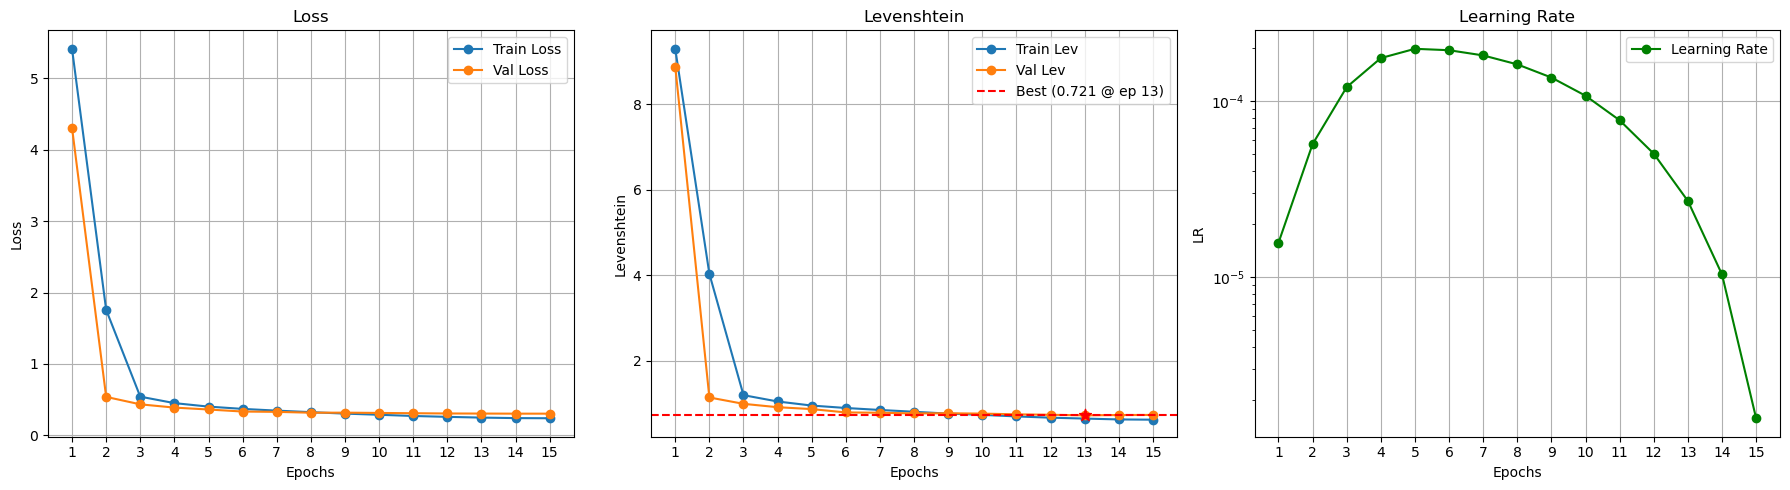


--- Ячейка 13: Основной цикл обучения завершен ---
--------------------------------------------------


In [65]:
# =============================================================================
# Ячейка 13: Основной Цикл Обучения (с MLflow)
# =============================================================================
print("--- Ячейка 13: Запуск Основного Цикла Обучения (с MLflow) ---")

# --- Добавляем импорты MLflow ---
import mlflow
import mlflow.pytorch # Для интеграции с PyTorch (опционально для автологирования, но полезно для log_model)
print(f"MLflow Версия: {mlflow.__version__}")

# --- Проверки готовности ---
required_vars = [ # Проверяем все, включая mlflow
    'model_created_successfully', 'model', 'criterion', 'optimizer', 'mlflow', # Заменили wandb на mlflow
    'train_df', 'index_to_char', 'char_to_index', 'AUDIO_CONFIG', 'MODEL_CONFIG', 'TRAIN_CONFIG',
    'device', 'collate_fn', 'MorseDataset', 'train_epoch', 'validate_epoch',
    'BEST_MODEL_PATH', 'PARAMS_PATH', 'EXTRACTED_AUDIO_DIR', 'BLANK_IDX', 'PAD_IDX'
]
missing_vars = [v for v in required_vars if v not in globals() or globals()[v] is None]
if missing_vars: raise SystemExit(f"Остановка: Отсутствуют компоненты для обучения: {missing_vars}")
if not model_created_successfully: raise SystemExit("Остановка: Модель не создана.")

# --- Подготовка Dataset и DataLoaders ---
train_loader, val_loader = None, None; main_loaders_ready = False
print("\nПодготовка Dataset и DataLoaders...")
try:
    # (Код создания Dataset и DataLoader без изменений)
    full_train_dataset = MorseDataset(
        dataframe=train_df, audio_dir=EXTRACTED_AUDIO_DIR, char_to_index=char_to_index,
        audio_config=AUDIO_CONFIG, model_input_feature_dim=MODEL_CONFIG['input_feature_dim'],
        train_config=TRAIN_CONFIG, is_train=True )
    if len(full_train_dataset) == 0: raise ValueError("Обучающий датасет пуст!")
    dataset_size = len(full_train_dataset); val_split_ratio = TRAIN_CONFIG['validation_split_ratio']
    val_size = int(np.floor(val_split_ratio * dataset_size)); train_size = dataset_size - val_size
    if train_size <= 0 or val_size <= 0: raise ValueError(f"Некорректное разделение: Train={train_size}, Val={val_size}")
    print(f"Разделение: Train={train_size}, Validation={val_size}")
    train_subset, val_subset = random_split(full_train_dataset, [train_size, val_size],
                                            generator=torch.Generator().manual_seed(TRAIN_CONFIG['base_seed']))
    bs = TRAIN_CONFIG['batch_size']; nw = TRAIN_CONFIG['num_workers']; pm = (device.type == 'cuda')
    train_loader = DataLoader(train_subset, batch_size=bs, shuffle=True, collate_fn=collate_fn, num_workers=nw, pin_memory=pm)
    val_loader = DataLoader(val_subset, batch_size=bs*2, shuffle=False, collate_fn=collate_fn, num_workers=nw, pin_memory=pm)
    print(f"Созданы Train ({len(train_loader)} батчей) и Val ({len(val_loader)} батчей) DataLoaders.")
    main_loaders_ready = True
except Exception as e: print(f"Критическая ошибка DataLoader: {e}"); traceback.print_exc(); main_loaders_ready = False

# --- Инициализация Планировщика OneCycleLR ---
scheduler = None
if main_loaders_ready and train_loader is not None:
    try:
        # (Код инициализации OneCycleLR без изменений)
        steps_per_epoch = len(train_loader);
        if steps_per_epoch == 0: raise ValueError("Train loader имеет 0 батчей!")
        total_steps = TRAIN_CONFIG['num_epochs'] * steps_per_epoch
        max_lr = TRAIN_CONFIG['learning_rate']; final_div = TRAIN_CONFIG.get('final_div_factor', 1e4)
        print(f"\nИнициализация OneCycleLR: total_steps={total_steps}, max_lr={max_lr:.1e}, final_div_factor={final_div}")
        scheduler = OneCycleLR(optimizer, max_lr=max_lr, total_steps=total_steps,
                               pct_start=0.3, anneal_strategy='cos', div_factor=25.0, final_div_factor=final_div)
        print("Планировщик OneCycleLR создан.")
    except Exception as e: print(f"!!! Ошибка OneCycleLR: {e} !!!"); traceback.print_exc(); scheduler = None; main_loaders_ready = False

# --- Настройка и Запуск MLflow ---
mlflow_enabled = False # Флаг для проверки успешности запуска
if main_loaders_ready and scheduler is not None:
    print("\nНастройка MLflow...")
    try:
        # Задаем имя эксперимента (если его нет, он будет создан)
        mlflow.set_experiment("Morse Recognition Training")
        mlflow_enabled = True
        print(f"MLflow готов. Логи будут сохраняться локально в папку './mlruns'.")
        print("Запустите 'mlflow ui' в терминале в папке проекта для просмотра.")
    except Exception as e:
        print(f"!!! Ошибка настройки MLflow: {e}. Обучение продолжится без логирования в MLflow.")

# --- Основной Цикл Обучения ---
if main_loaders_ready and scheduler is not None:
    # --- Начинаем MLflow Run ---
    with mlflow.start_run(run_name=f"train_{FINAL_SUFFIX}"): # Используем 'with', чтобы run завершился автоматически
        print(f"\n--- Начало основного обучения ({TRAIN_CONFIG['num_epochs']} эпох) ---")
        print(f"MLflow Run ID: {mlflow.active_run().info.run_id}")
        print(f"Модель будет сохранена как: {BEST_MODEL_PATH.name}")

        # Логирование параметров в MLflow
        if mlflow_enabled:
            print("Логирование параметров в MLflow...")
            mlflow.log_param("seed", SEED)
            mlflow.log_params(TRAIN_CONFIG)
            # Логируем словари аудио и модели "как есть"
            # MLflow UI может отображать их как JSON/YAML
            mlflow.log_dict(AUDIO_CONFIG, "audio_config.json")
            mlflow.log_dict(MODEL_CONFIG, "model_config.json")
            # Можно также логировать отдельные вложенные параметры, если нужно их сравнивать напрямую
            # mlflow.log_param("cnn_kernel_size", MODEL_CONFIG["cnn_kernel_size"])

        start_time_total = time.time()
        best_val_levenshtein = float('inf'); epochs_without_improvement = 0
        best_model_local_path = None; best_epoch_num = None # Переменные для лучшей модели/эпохи
        # Словарь для локальных графиков (если нужен)
        training_history = {'train_loss': [], 'train_lev': [], 'val_loss': [], 'val_lev': [], 'lr': []}

        try:
            for epoch in range(1, TRAIN_CONFIG['num_epochs'] + 1):
                epoch_start_time = time.time()
                print(f"\n--- Эпоха {epoch}/{TRAIN_CONFIG['num_epochs']} ---")
                # --- Тренировка ---
                avg_train_loss, avg_train_lev, avg_epoch_lr = train_epoch(
                    model=model, dataloader=train_loader, criterion=criterion, optimizer=optimizer,
                    scheduler=scheduler, device=device, epoch_num=epoch, total_epochs=TRAIN_CONFIG['num_epochs'],
                    index_to_char_map=index_to_char, blank_idx=BLANK_IDX, pad_idx=PAD_IDX,
                    grad_clip_norm=TRAIN_CONFIG['gradient_clip_norm'] )
                # --- Валидация ---
                avg_val_loss, avg_val_lev, val_examples = validate_epoch(
                    model=model, dataloader=val_loader, criterion=criterion, device=device,
                    index_to_char_map=index_to_char, blank_idx=BLANK_IDX, pad_idx=PAD_IDX )
                epoch_duration = time.time() - epoch_start_time

                # Запись в локальную историю для графиков matplotlib
                training_history['train_loss'].append(avg_train_loss)
                training_history['train_lev'].append(avg_train_lev)
                training_history['val_loss'].append(avg_val_loss)
                training_history['val_lev'].append(avg_val_lev)
                training_history['lr'].append(avg_epoch_lr)

                # --- Логирование метрик в MLflow (если включен) ---
                if mlflow_enabled:
                    mlflow.log_metric("train_loss", avg_train_loss, step=epoch)
                    mlflow.log_metric("train_levenshtein", avg_train_lev, step=epoch)
                    mlflow.log_metric("val_loss", avg_val_loss, step=epoch)
                    mlflow.log_metric("val_levenshtein", avg_val_lev, step=epoch)
                    mlflow.log_metric("learning_rate", avg_epoch_lr, step=epoch)

                # --- Вывод результатов эпохи ---
                print(f"\nИтоги Эпохи {epoch}/{TRAIN_CONFIG['num_epochs']} | Время: {epoch_duration:.2f} сек | Ср.LR: {avg_epoch_lr:.3e}")
                print(f"  Train Loss: {avg_train_loss:.4f} | Train Levenshtein: {avg_train_lev:.4f}")
                print(f"  Val Loss:   {avg_val_loss:.4f} | Val Levenshtein:   {avg_val_lev:.4f}")
                print("  Примеры декодирования (Greedy):")
                for i, (pred, real) in enumerate(val_examples[:5]): print(f"    {i+1}: '{pred[:70]}' | '{real[:70]}'")

                # --- Сохранение лучшей модели ЛОКАЛЬНО и Early Stopping ---
                if np.isfinite(avg_val_lev) and avg_val_lev < best_val_levenshtein:
                    print(f"  ✨ Val Lev улучшился: {best_val_levenshtein:.4f} -> {avg_val_lev:.4f}. Сохранение локальной модели...")
                    best_val_levenshtein = avg_val_lev; best_epoch_num = epoch
                    best_model_local_path = OUTPUT_DIR / f"temp_best_model_mlflow_{mlflow.active_run().info.run_id if mlflow_enabled else 'local'}.pth"
                    try:
                        torch.save(model.state_dict(), best_model_local_path)
                        print(f"  Временная модель сохранена в: {best_model_local_path}")
                    except Exception as save_err: print(f"  !!! Ошибка сохранения временной модели: {save_err} !!!")
                    epochs_without_improvement = 0
                else:
                    epochs_without_improvement += 1
                    print(f"  Val Lev не улучшился ({avg_val_lev:.4f} vs best {best_val_levenshtein:.4f}). Эпох без улучшений: {epochs_without_improvement}/{TRAIN_CONFIG['early_stopping_patience']}")
                if epochs_without_improvement >= TRAIN_CONFIG['early_stopping_patience']:
                    print(f"\n❗️ Ранняя остановка!"); break
                print("-" * 60)

        except KeyboardInterrupt: print("\nОбучение прервано пользователем.")
        except RuntimeError as e:
            if "CUDA out of memory" in str(e): print("\n!!! Критическая ошибка: CUDA OOM !!!")
            else: print(f"\n!!! Runtime Error: {e} !!!"); traceback.print_exc()
        except Exception as train_err: print(f"\n!!! НЕПРЕДВИДЕННАЯ ОШИБКА ОБУЧЕНИЯ: {train_err} !!!"); traceback.print_exc()
        finally:
            total_training_time = time.time() - start_time_total
            print(f"\n--- Основное Обучение Завершено ---")
            print(f"Общее время: {total_training_time / 60:.2f} мин")
            best_lev_str = f"{best_val_levenshtein:.4f}" if np.isfinite(best_val_levenshtein) else "N/A"
            best_epoch_str = str(best_epoch_num) if best_epoch_num is not None else "?"
            print(f"Лучший Val Levenshtein: {best_lev_str} (на эпохе {best_epoch_str})")

            # --- Логирование финальных метрик и артефактов в MLflow ---
            if mlflow_enabled:
                print("\nЛогирование артефактов и финальных метрик в MLflow...")
                try:
                    # Логируем лучшую метрику
                    if np.isfinite(best_val_levenshtein):
                         mlflow.log_metric("best_val_levenshtein", best_val_levenshtein)
                         if best_epoch_num is not None:
                              mlflow.log_metric("best_epoch", best_epoch_num)

                    # Логируем лучшую модель как артефакт
                    if best_model_local_path and best_model_local_path.exists() and np.isfinite(best_val_levenshtein):
                         # Вариант 1: Логирование как простой файл .pth
                         mlflow.log_artifact(str(best_model_local_path), artifact_path="model")
                         print(f"  Артефакт модели '{best_model_local_path.name}' залогирован (как .pth файл).")
                         # Вариант 2: Логирование в формате mlflow.pytorch (создаст папку)
                         # mlflow.pytorch.log_model(model, "pytorch_model", registered_model_name="MorseRecognizerModel") # Загружает текущее состояние модели!
                         # print(f"  Модель залогирована в формате mlflow.pytorch.")
                    elif np.isfinite(best_val_levenshtein):
                         print(f"  Артефакт модели не логирован (файл {best_model_local_path} не найден?).")

                    # Сохраняем и логируем финальные параметры
                    final_params_to_save = {
                        'audio_config': AUDIO_CONFIG, 'model_config': MODEL_CONFIG, 'train_config': TRAIN_CONFIG,
                        'char_map': { 'char_to_index': char_to_index, 'index_to_char': {k:v for k,v in index_to_char.items()},
                                      'BLANK_IDX': BLANK_IDX, 'PAD_IDX': PAD_IDX, 'NUM_CLASSES_CTC': NUM_CLASSES_CTC },
                        'best_val_levenshtein': best_val_levenshtein if np.isfinite(best_val_levenshtein) else None,
                        'best_epoch': best_epoch_num
                    }
                    params_temp_path = OUTPUT_DIR / f"params_{mlflow.active_run().info.run_id}.json"
                    with open(params_temp_path, 'w', encoding='utf-8') as f:
                        json.dump(final_params_to_save, f, indent=4, ensure_ascii=False)
                    mlflow.log_artifact(str(params_temp_path), artifact_path="config")
                    print(f"  Артефакт конфигурации '{params_temp_path.name}' залогирован.")
                    # Сохраняем копию с финальным именем локально
                    try:
                        PARAMS_PATH.parent.mkdir(parents=True, exist_ok=True)
                        params_temp_path.rename(PARAMS_PATH) # Переименовываем временный файл в финальный
                        print(f"  Локальный файл параметров сохранен/переименован в: {PARAMS_PATH}")
                    except Exception as e:
                        print(f"  Ошибка переименования файла параметров: {e}. Финальный конфиг остался в: {params_temp_path}")
                        # Не удаляем временный файл, если не удалось переименовать
                        # Можно скопировать, если rename не работает на разных дисках/разделах
                        # import shutil
                        # shutil.copy2(params_temp_path, PARAMS_PATH)


                except Exception as e:
                     print(f"!!! Ошибка логирования артефактов/метрик в MLflow: {e} !!!")
            else:
                # Если MLflow не включен, просто сохраняем параметры локально
                 print("\nСохранение финальных параметров конфигурации (локально)...")
                 final_params_to_save = {
                     'audio_config': AUDIO_CONFIG, 'model_config': MODEL_CONFIG, 'train_config': TRAIN_CONFIG,
                     'char_map': { 'char_to_index': char_to_index, 'index_to_char': {k:v for k,v in index_to_char.items()},
                                   'BLANK_IDX': BLANK_IDX, 'PAD_IDX': PAD_IDX, 'NUM_CLASSES_CTC': NUM_CLASSES_CTC },
                     'best_val_levenshtein': best_val_levenshtein if np.isfinite(best_val_levenshtein) else None,
                     'best_epoch': best_epoch_num
                 }
                 try:
                      PARAMS_PATH.parent.mkdir(parents=True, exist_ok=True)
                      with open(PARAMS_PATH, 'w', encoding='utf-8') as f:
                          json.dump(final_params_to_save, f, indent=4, ensure_ascii=False)
                      print(f"Параметры сохранены локально в: {PARAMS_PATH}")
                 except Exception as e: print(f"!!! Ошибка сохранения параметров: {e} !!!")


            # --- Переименование лучшей локальной модели в финальный путь ---
            # Делаем это после логирования в MLflow, на всякий случай
            if best_model_local_path and best_model_local_path.exists() and np.isfinite(best_val_levenshtein):
                 try:
                     BEST_MODEL_PATH.parent.mkdir(parents=True, exist_ok=True)
                     # Проверяем, не совпадает ли временный путь с финальным (маловероятно, но все же)
                     if best_model_local_path.resolve() != BEST_MODEL_PATH.resolve():
                          best_model_local_path.rename(BEST_MODEL_PATH)
                          print(f"Лучшая локальная модель перемещена в: {BEST_MODEL_PATH}")
                     else:
                          print(f"Лучшая модель уже находится по финальному пути: {BEST_MODEL_PATH}")
                 except Exception as e:
                     print(f"!!! Ошибка перемещения лучшей модели из {best_model_local_path} в {BEST_MODEL_PATH}: {e} !!!")
                     print(f"    Лучшая модель осталась в: {best_model_local_path}")
            elif np.isfinite(best_val_levenshtein):
                 print(f"!!! Предупреждение: Файл лучшей модели {best_model_local_path} не найден для финального перемещения.")
            else:
                 print("!!! Лучшая модель не была сохранена (нет конечного результата Levenshtein).")


            # --- Построение графиков обучения (Локально) ---
            print("\nПостроение локальных графиков истории обучения...")
            if training_history and training_history.get('train_loss'):
                 epochs_completed = len(training_history['train_loss'])
                 if epochs_completed > 0:
                     # (Код matplotlib без изменений)
                     epoch_axis = range(1, epochs_completed + 1)
                     plt.figure(figsize=(18, 5)); plt.subplot(1, 3, 1)
                     plt.plot(epoch_axis, training_history['train_loss'], 'o-', label='Train Loss'); plt.plot(epoch_axis, training_history['val_loss'], 'o-', label='Val Loss')
                     plt.title('Loss'); plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.legend(); plt.grid(True); plt.xticks(np.arange(1,epochs_completed+1, step=max(1,epochs_completed//10)))
                     plt.subplot(1, 3, 2); plt.plot(epoch_axis, training_history['train_lev'], 'o-', label='Train Lev'); plt.plot(epoch_axis, training_history['val_lev'], 'o-', label='Val Lev')
                     if np.isfinite(best_val_levenshtein):
                         best_ep_idx = np.argmin(training_history['val_lev']); best_ep = best_ep_idx + 1
                         plt.axhline(y=best_val_levenshtein, color='r', linestyle='--', label=f'Best ({best_val_levenshtein:.3f} @ ep {best_ep})')
                         plt.scatter(best_ep, best_val_levenshtein, c='r', s=80, zorder=5, marker='*')
                     plt.title('Levenshtein'); plt.xlabel('Epochs'); plt.ylabel('Levenshtein'); plt.legend(); plt.grid(True); plt.xticks(np.arange(1,epochs_completed+1, step=max(1,epochs_completed//10))); min_val_lev = min(training_history.get('val_lev', [0])); plt.ylim(bottom=max(0, min_val_lev - 0.5))
                     plt.subplot(1, 3, 3); plt.plot(epoch_axis, training_history['lr'], 'o-', label='Learning Rate', color='g'); plt.title('Learning Rate'); plt.xlabel('Epochs'); plt.ylabel('LR'); plt.legend(); plt.grid(True); plt.yscale('log'); plt.xticks(np.arange(1,epochs_completed+1, step=max(1,epochs_completed//10)))
                     plt.tight_layout(); plt.show()
                 else: print("Нет данных для локальных графиков.")
            else: print("Локальные графики не строятся (нет истории).")

        # Run завершается автоматически при выходе из блока 'with'

else:
    print("\n--- Основное Обучение Не Запущено (проблемы с подготовкой данных / планировщиком / MLflow) ---")

print("\n--- Ячейка 13: Основной цикл обучения завершен ---")
print("-" * 50)
# =============================================================================

### Ячейка 14: Генерация Предсказаний (Submission)

In [66]:
# =============================================================================
# Ячейка 14: Генерация Предсказаний (Submission)
# =============================================================================
print("--- Ячейка 14: Генерация Предсказаний для Теста (Greedy) ---")

# --- Проверки наличия файлов и переменных ---
# Убедимся, что модель и параметры существуют локально
model_file_exists = 'BEST_MODEL_PATH' in globals() and BEST_MODEL_PATH is not None and BEST_MODEL_PATH.is_file()
params_file_exists = 'PARAMS_PATH' in globals() and PARAMS_PATH is not None and PARAMS_PATH.is_file()
test_df_exists = 'test_df' in globals() and test_df is not None and not test_df.empty
# Доп. переменные для инференса
required_infer_vars = [ 'MorseRecognizer', 'MorseDataset', 'collate_fn', 'device', 'ctc_greedy_decode',
                        'index_to_char', 'BLANK_IDX', 'PAD_IDX', 'tqdm', 'torch', 'json', 'Path',
                        'pd', 'DataLoader', 'np', 'EXTRACTED_AUDIO_DIR', 'TRAIN_CONFIG', 'F', 'MODEL_CONFIG', 'OUTPUT_DIR']
missing_infer_vars = [v for v in required_infer_vars if v not in globals() or globals()[v] is None]

can_infer = not missing_infer_vars and model_file_exists and params_file_exists and test_df_exists

if can_infer:
    print(f"Загрузка модели из ЛОКАЛЬНОГО файла: {BEST_MODEL_PATH}")
    print(f"Загрузка параметров из ЛОКАЛЬНОГО файла: {PARAMS_PATH}")

    # --- Загрузка параметров конфигурации из ЛОКАЛЬНОГО файла JSON ---
    print("\n1. Загрузка параметров конфигурации...")
    loaded_params_infer = None; params_loaded = False
    try:
        with open(PARAMS_PATH, 'r', encoding='utf-8') as f: loaded_params_infer = json.load(f)
        loaded_audio_config_inf = loaded_params_infer['audio_config']; loaded_model_config_inf = loaded_params_infer['model_config']
        loaded_char_map_inf = loaded_params_infer['char_map']; loaded_char_to_index_inf = loaded_char_map_inf['char_to_index']
        loaded_index_to_char_inf = {int(k) if k.isdigit() else k: v for k,v in loaded_char_map_inf['index_to_char'].items()}
        loaded_blank_idx_inf = loaded_char_map_inf['BLANK_IDX']; loaded_pad_idx_inf = loaded_char_map_inf['PAD_IDX']
        loaded_num_classes_inf = loaded_char_map_inf['NUM_CLASSES_CTC']; loaded_input_dim_inf = loaded_model_config_inf['input_feature_dim']
        print("   Параметры успешно загружены."); params_loaded = True
    except Exception as e: print(f"   !!! Ошибка загрузки/парсинга параметров: {e} !!!"); traceback.print_exc(limit=1)

    # --- Создание модели и загрузка весов из ЛОКАЛЬНОГО файла ---
    inference_model = None; model_loaded = False
    if params_loaded:
        print(f"\n2. Создание модели для инференса...");
        try:
            temp_model_config = loaded_model_config_inf.copy(); temp_model_config.pop('input_feature_dim', None)
            inference_model = MorseRecognizer(num_classes_ctc=loaded_num_classes_inf, input_feature_dim=loaded_input_dim_inf, **temp_model_config).to(device)
            print(f"   Загрузка весов из: {BEST_MODEL_PATH}...");
            # Используем weights_only=True для безопасности
            try: inference_model.load_state_dict(torch.load(BEST_MODEL_PATH, map_location=device, weights_only=True))
            except TypeError: print("   Warning: weights_only=True не поддерживается."); inference_model.load_state_dict(torch.load(BEST_MODEL_PATH, map_location=device))
            inference_model.eval(); print("   Модель создана и веса загружены."); model_loaded = True
        except Exception as e: print(f"   !!! Ошибка создания/загрузки модели: {e} !!!"); traceback.print_exc(limit=1)

    # --- Создание тестового DataLoader ---
    test_loader_infer = None; test_loader_ready = False
    if model_loaded:
        print("\n3. Создание тестового DataLoader...")
        try:
             loaded_train_config_inf = loaded_params_infer.get('train_config', TRAIN_CONFIG) # Берем из файла, если есть
             infer_test_dataset = MorseDataset(
                 dataframe=test_df, audio_dir=EXTRACTED_AUDIO_DIR, char_to_index=loaded_char_to_index_inf,
                 audio_config=loaded_audio_config_inf, model_input_feature_dim=loaded_input_dim_inf,
                 train_config=loaded_train_config_inf, is_train=False )
             inf_bs = TRAIN_CONFIG.get('batch_size', 8) * 4; inf_nw = TRAIN_CONFIG.get('num_workers', 0)
             test_loader_infer = DataLoader( infer_test_dataset, batch_size=inf_bs, shuffle=False,
                 collate_fn=collate_fn, num_workers=inf_nw, pin_memory=(device.type == 'cuda') )
             print(f"   Тестовый DataLoader создан (Batch Size={inf_bs})."); test_loader_ready = True
        except Exception as e: print(f"   !!! Ошибка создания тестового DataLoader: {e} !!!"); traceback.print_exc(limit=1)

    # --- Запуск Инференса ---
    if test_loader_ready and inference_model is not None:
        predictions = {}; print("\n4. Запуск инференса..."); inference_start_time = time.time()
        inference_model.eval();
        with torch.no_grad():
            pbar_infer = tqdm(test_loader_infer, desc="Предсказание (Greedy)", ncols=1000, leave=True)
            for batch_data in pbar_infer:
                if batch_data is None: continue
                features, file_ids, _, _ = batch_data # Длины не нужны для инференса
                if features is None or file_ids is None or features.shape[0]==0: continue
                features = features.to(device, non_blocking=True)
                try:
                    logits = inference_model(features) # (T, B, C)
                    decoded_batch = ctc_greedy_decode(logits, loaded_index_to_char_inf, loaded_blank_idx_inf)
                except Exception as e: print(f"\nОшибка Forward/Decode: {e}"); decoded_batch = ["ERROR_INFER"] * len(file_ids)
                for file_id, pred_text in zip(file_ids, decoded_batch): predictions[file_id] = pred_text
        inference_duration = time.time() - inference_start_time
        print(f"\n   Инференс завершен за {inference_duration:.2f} сек.")
        print(f"   Предсказаний в словаре: {len(predictions)} (ожидалось: {len(test_df)})")
        if len(predictions) != len(test_df): print("   !!! ПРЕДУПРЕЖДЕНИЕ: Кол-во предсказаний не совпадает с test_df! Возможны пропуски.")

        # --- Формирование и сохранение submission ---
        if predictions:
            print("\n5. Формирование и сохранение файла submission...")
            submission_df = pd.DataFrame({'id': test_df['id']})
            submission_df['message'] = submission_df['id'].map(predictions).fillna("ERROR_MISSING_PRED")
            num_empty = (submission_df['message'] == "").sum(); num_errors = submission_df['message'].str.contains("ERROR").sum()
            if num_empty > 0: print(f"  Предупреждение: Найдено {num_empty} пустых предсказаний.")
            if num_errors > 0: print(f"  Предупреждение: Найдено {num_errors} предсказаний с ошибками.")
            # Используем финальный суффикс
            submission_filename = f"submission_greedy_{FINAL_SUFFIX}.csv"
            submission_path = OUTPUT_DIR / submission_filename
            try:
                submission_df.to_csv(submission_path, index=False)
                print(f"   Файл submission сохранен: {submission_path.resolve()}")
                print(f"\n   Последние 17 строк файла submission:")
                display(submission_df.tail(17))
            except Exception as e: print(f"   !!! Ошибка сохранения submission: {e} !!!")
        else: print("   Предсказания не сгенерированы, файл submission не создан.")

elif not can_infer:
    print("\n--- Инференс Не Запущен ---")
    if missing_infer_vars: print(f"  Причина: Отсутствуют переменные: {missing_infer_vars}")
    if not model_file_exists: print(f"  Причина: Файл модели не найден: {globals().get('BEST_MODEL_PATH', 'Путь не определен')}")
    if not params_file_exists: print(f"  Причина: Файл параметров не найден: {globals().get('PARAMS_PATH', 'Путь не определен')}")
    if not test_df_exists: print("  Причина: test_df не загружен/пуст.")

print("\n--- Ячейка 14: Работа ноутбука завершена ---")
print("=" * 60)
# =============================================================================

--- Ячейка 14: Генерация Предсказаний для Теста (Greedy) ---
Загрузка модели из ЛОКАЛЬНОГО файла: C:\Users\vasja\OneDrive\Рабочий стол\MorseAudioDecoder\output\model_RMS1764h441_CNNk9p2_RNN256x2_Feat2_LR2e-04_WD1e-04_SR44k_Deltastandard_NormZscore_FiltOFF_cropNONE.pth
Загрузка параметров из ЛОКАЛЬНОГО файла: C:\Users\vasja\OneDrive\Рабочий стол\MorseAudioDecoder\output\params_RMS1764h441_CNNk9p2_RNN256x2_Feat2_LR2e-04_WD1e-04_SR44k_Deltastandard_NormZscore_FiltOFF_cropNONE.json

1. Загрузка параметров конфигурации...
   Параметры успешно загружены.

2. Создание модели для инференса...
Архитектура MorseRecognizer инициализирована.
   Загрузка весов из: C:\Users\vasja\OneDrive\Рабочий стол\MorseAudioDecoder\output\model_RMS1764h441_CNNk9p2_RNN256x2_Feat2_LR2e-04_WD1e-04_SR44k_Deltastandard_NormZscore_FiltOFF_cropNONE.pth...
   Модель создана и веса загружены.

3. Создание тестового DataLoader...
MorseDataset создан: is_train=False, delta_type='standard', Фильтр=0-22049Hz (Порядок 5), Сгл

Предсказание (Greedy):   0%|                                                                                  …


   Инференс завершен за 77.13 сек.
   Предсказаний в словаре: 5000 (ожидалось: 5000)

5. Формирование и сохранение файла submission...
   Файл submission сохранен: C:\Users\vasja\OneDrive\Рабочий стол\MorseAudioDecoder\output\submission_greedy__SR44k_Deltastandard_NormZscore_FiltOFF_cropNONE.csv

   Последние 17 строк файла submission:


,id,message
4983,34984.opus,ДАМИНАМТ ДОТИ РСЫСАМЦ2
4984,34985.opus,ИЛ ЬСВЕДТКЧВНТИ ЯМДМЫМЮНЯМЦ ЮТИЫМ ЬТКТЧМЫН ДТЫ...
4985,34986.opus,АНХ ВСОЕГЬ Р ВКТДАМИ НКШМДНИ ГЕКНЖТА
4986,34987.opus,ИЛ ДАСДП ЬСОЕМУНТИ ИГВКСОЕП ЬКСХЫСУС ХНУ ЮН ХНУСИ
4987,34988.opus,ЕТЬТКП ДСЯНКМЫОЦ ИМК Ы
4988,34989.opus,КНОЬКМ СОЕНЫМОП ЬСЮНВМ 2ШЫРЫЫРЯЫ Ш #
4989,34990.opus,ИЛ ЬСОЕНДМЫМ ЙЫНУС ЙЫМЧАТУС ЬКТДЛХТ ЫМЖАЛШ ДЛУ...
4990,34991.opus,ИЛ ДАСДП ОСЮВНЫМ НЮЙГРГ ЕТЫТУКНЩН ЬЪ ЙШ
4991,34992.opus,АС АТ ИСЧТИ КГЖНЕПОЦ Ю НЙОСЫЗЕАЗ ДКАСОЕП ОМИДСЫСД
4992,34993.opus,ОЫМДЛ ОЫЛ1ЕТ #ЕС Ь0ЫН2Т ЕСПЕРЫ9АМЕШП



--- Ячейка 14: Работа ноутбука завершена ---
